# Кластерный анализ для формирования устойчивого инвестиционного портфеля

## Импортирование библиотек

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install PyPortfolioOpt
clear_output()

In [ ]:
# !pip install yfinance --upgrade --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np

import requests
import copy

from datetime import timedelta, datetime

from collections import OrderedDict

import yfinance as yf

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler


from pypfopt import base_optimizer
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
import pypfopt.plotting as pplt


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

## Скачивание данных

### Функции для скачивания с Википедии

In [ ]:
# Скачиваем список тикеров акций из индекса S&P 500 из Википедии

def get_tickers():
    wiki_page = requests.get(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    ).text

    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']

    return ticker_options

In [ ]:
# Вызываем функцию get_tickers
# Конвертируем полученный результат в список и заменяем
# тикеры, у которых есть '.' знаком '-', чтобы скачать данные из библиотеки

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))

503


### 200 крупнейших компаний из индекса S&P 500

In [ ]:
# https://drive.google.com/file/d/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q/view?usp=share_link

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q' -O tickers-top-200.csv

--2023-05-08 23:17:52--  https://docs.google.com/uc?export=download&id=1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q
Resolving docs.google.com (docs.google.com)... 142.251.163.101, 142.251.163.139, 142.251.163.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.163.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8oiq9tgvcdkf7a861dtpifsmse0fs4b7/1683587850000/11915959673283641640/*/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q?e=download&uuid=5ee1fed8-80c6-47af-bc9b-73f27d99806a [following]
--2023-05-08 23:17:52--  https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8oiq9tgvcdkf7a861dtpifsmse0fs4b7/1683587850000/11915959673283641640/*/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q?e=download&uuid=5ee1fed8-80c6-47af-bc9b-73f27d99806a
Resolving doc-0k-60-docs.googleusercontent.com (doc-0k-60-docs.googleusercontent.com)... 142.251.16.132, 2607:f

In [ ]:
stock_tickers = pd.read_csv('tickers-top-200.csv', header=None)

In [ ]:
stock_tickers

,0
0,AAPL
1,MSFT
2,AMZN
3,NVDA
4,GOOGL
...,...
195,LHX
196,HLT
197,CHTR
198,NUE


In [ ]:
stock_tickers = list(stock_tickers[0].values)

In [ ]:
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

In [ ]:
type(stock_tickers)

list

### Библиотека yfinance

In [ ]:
df_stocks= yf.download(stock_tickers, 
                       start='2020-01-01', 
                       end='2023-04-01')['Adj Close']

[*********************100%***********************]  200 of 200 completed


In [ ]:
df_stocks.index = pd.to_datetime(df_stocks.index)

In [ ]:
df_stocks.isna().sum().sum()

0

In [ ]:
df_stocks.T

Date,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
A,84.108360,82.757935,83.002571,83.257004,84.079002,85.400063,85.713219,85.586014,86.104652,86.721153,...,134.321167,136.787155,133.512497,130.916733,131.745377,132.853577,132.414291,133.632309,134.271271,138.114990
AAPL,73.449387,72.735313,73.314888,72.970070,74.143890,75.718765,75.889946,77.511314,76.464638,76.136955,...,157.399994,159.279999,157.830002,158.929993,160.250000,158.279999,157.649994,160.770004,162.360001,164.899994
ABBV,76.495049,75.768951,76.366920,75.931259,76.469421,77.058823,76.076469,75.615196,76.359756,77.277451,...,154.696884,155.340958,152.269211,153.884369,156.579575,156.103928,156.807465,156.559753,156.480469,157.917252
ABT,82.122162,81.121025,81.546036,81.092690,81.423264,81.640480,80.620438,80.393784,81.323296,82.878784,...,97.383324,97.841034,96.378342,96.557449,97.562431,97.970390,96.627106,98.129593,98.587311,100.756470
ACN,199.948456,199.615448,198.311981,194.030411,194.410980,196.142624,197.579315,199.415634,197.645950,197.961121,...,251.562134,256.612305,252.279327,270.597382,270.936066,272.888367,273.924316,278.845001,281.554352,284.692047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WM,108.035034,109.084938,109.652443,109.728104,109.794319,109.841621,109.907799,111.288765,111.676559,111.818428,...,154.869995,154.509995,152.089996,150.699997,154.460007,153.580002,154.820007,157.039993,161.529999,163.169998
WMT,112.483597,111.490601,111.263618,110.232780,109.854507,110.989365,110.062561,109.589684,109.873413,109.022278,...,140.366776,139.888596,138.992004,140.117722,141.263382,143.624405,143.066528,143.684174,145.118729,146.891998
XEL,57.058811,57.333229,57.250896,57.131996,57.077106,57.205158,57.296631,57.964359,58.055828,58.970531,...,67.389999,65.500000,64.150002,63.310001,65.550003,65.290001,65.400002,66.540001,66.910004,67.440002
XOM,59.038692,58.564049,59.013706,58.530743,57.648079,58.089405,57.573124,58.122719,57.623085,57.531498,...,102.449997,107.040001,104.589996,103.410004,103.529999,105.800003,107.120003,108.959999,109.489998,109.660004


In [ ]:
# df_stocks = df_stocks.ffill(axis=1)

### Котировки индекса S&P 500

In [ ]:
# https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?resource=download&select=sp500_companies.csv

In [ ]:
# https://drive.google.com/file/d/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy/view?usp=sharing

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy' -O sp500_index.csv

--2023-05-08 23:18:31--  https://docs.google.com/uc?export=download&id=1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy
Resolving docs.google.com (docs.google.com)... 142.251.16.138, 142.251.16.101, 142.251.16.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ln8teq4toljnr23dmil51blkabqcllr0/1683587850000/11915959673283641640/*/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy?e=download&uuid=5a6120a8-7c36-49a6-81e4-06184be98731 [following]
--2023-05-08 23:18:32--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ln8teq4toljnr23dmil51blkabqcllr0/1683587850000/11915959673283641640/*/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy?e=download&uuid=5a6120a8-7c36-49a6-81e4-06184be98731
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 142.251.16.132, 2607:f8b0:

In [ ]:
index_df = pd.read_csv('sp500_index.csv')
index_df.index = pd.to_datetime(index_df['Date'])
index_df = index_df.drop('Date', axis=1)

In [ ]:
index_df

,S&P500
Date,
2013-05-03,1614.42
2013-05-06,1617.50
2013-05-07,1625.96
2013-05-08,1632.69
2013-05-09,1626.67
...,...
2023-04-26,4055.99
2023-04-27,4135.35
2023-04-28,4169.48


## Вспомогательные функции

### Функции для кластеризации

In [ ]:
def get_corr_dissimilarity_matrix(stocks_df: pd.DataFrame) -> np.ndarray:
    corr = np.corrcoef(stocks_df.T)
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    dissimilarity = np.sqrt(2 * (1 - corr))
    np.triu(dissimilarity)

    return np.triu(dissimilarity)

In [ ]:
def get_df_between_dates(stocks_df: pd.DataFrame,
                         start_date: str, 
                         end_date: str,
                         time_delta: int = 0) -> pd.DataFrame:

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    stocks_df = stocks_df.copy()
    stocks_df['date'] = stocks_df.index
    stocks_df = stocks_df[
        (stocks_df['date'] >= start_date) & 
        (stocks_df['date'] - timedelta(days=time_delta) <= end_date)
    ].drop('date', axis=1)
        
    return stocks_df

In [ ]:
def calinski_harabasz_method(data: pd.DataFrame, 
                             linkage: str) -> None:

    wcss = []
    for i in range(2, 50):
        clust = AgglomerativeClustering(n_clusters = i, linkage = linkage)
        labels = clust.fit_predict(data)
        wcss.append(calinski_harabasz_score(data, labels))
    plt.plot(range (2, 50), wcss) 
    plt.title('The CH score') 
    plt.xlabel('Number of clusters') 
    plt.ylabel('CH score') 
    plt.show()

In [ ]:
def print_clusters(df_combined, cluster_labels):
  cluster_dict = {}
  for i, label in enumerate(cluster_labels):
      if label not in cluster_dict:
          cluster_dict[label] = []
      cluster_dict[label].append(df_combined.columns[i])

  # Print out the companies in each cluster
  for cluster, companies in cluster_dict.items():
      print(f"Cluster {cluster}: {', '.join(companies)}")
  return cluster_dict

In [ ]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Функции для оптимизации

In [ ]:
def optimize_portfolio(stocks_df: pd.DataFrame,
                       portfolio: list,
                       weight_bounds: tuple) -> OrderedDict:
    
    mu = expected_returns.mean_historical_return(stocks_df[portfolio])
    sigma = risk_models.sample_cov(stocks_df[portfolio])

    ef = EfficientFrontier(mu, sigma, weight_bounds=weight_bounds)
    sharpe_pfolio=ef.max_sharpe()
    sharpe_pwt=ef.clean_weights()
    print(sharpe_pwt)
    print()
    ef.portfolio_performance(verbose=True)
    
    return sharpe_pwt

In [ ]:
def get_sharpe_ratio_info(stocks_df: pd.DataFrame) -> pd.DataFrame:

    returns = expected_returns.mean_historical_return(df_stocks)
    returns = returns.reset_index()
    returns.columns = ['ticker', 'mean_return']

    risk_free_rate = 0.02

    variance = risk_models.sample_cov(df_stocks)
    returns['var'] = np.array(variance).diagonal()

    returns['sharpe_ratio'] = (returns['mean_return'] - 
                               risk_free_rate) / returns['var']

    return returns

In [ ]:
def get_portfolio_tickers(cluster_dict: dict,
                          sharpe_ratio_df: pd.DataFrame) -> list:

    portfolio = []
    for label in cluster_dict:
        cluster = sharpe_ratio_df[returns['ticker'].isin(cluster_dict[label])]

        portfolio.append(
            cluster.iloc[cluster['sharpe_ratio'].argmax()]['ticker']
        )
        
    return portfolio

In [ ]:
def calculate_port_cum_return(stocks_df: pd.DataFrame, 
                              portfolio: list, 
                              weights: OrderedDict) -> float:
    port_cum_ret = []
    for stock in portfolio:
        port_cum_ret.append(
            (stocks_df[stock][-1] - stocks_df[stock][0]) / stocks_df[stock][0]
            ) 
    
    port_cum_ret = pd.DataFrame(port_cum_ret, 
                                index=portfolio, 
                                columns=['cum_ret'])

    port_cum_ret['weight'] = list(weights.values())

    return (port_cum_ret['cum_ret'] * port_cum_ret['weight']).sum()

In [ ]:
def get_portfolio_beta_coef(stocks_df: pd.DataFrame,
                            index_df: pd.DataFrame,
                            portfolio: list,
                            weights: OrderedDict) -> float:  

    stocks = stocks_df.copy()
    returns = expected_returns.returns_from_prices(stocks[portfolio])
    weights = pd.DataFrame(weights, index=[0])
    for stock in portfolio:
        returns[stock] = returns[stock] * weights[stock].values[0]

    returns = np.array(returns.sum(axis=1))

    index_returns = np.squeeze(expected_returns.returns_from_prices(index_df))

    beta = np.cov(returns, index_returns)[0][1] / np.var(index_returns)

    return beta

In [ ]:
def get_portfolio_stats(stocks_df: pd.DataFrame,
                        index_df: pd.DataFrame,
                        start_date: str,
                        end_date: str,
                        portfolio: list,
                        weights: OrderedDict) -> None:

    df = get_df_between_dates(stocks_df,
                              start_date,
                              end_date)
    
    index = get_df_between_dates(index_df,
                                 start_date,
                                 end_date)

    exp_returns = expected_returns.mean_historical_return(df[portfolio],
                                                          frequency=df.shape[0]) 

    cov_matrix = risk_models.sample_cov(df[portfolio],
                                        frequency=df.shape[0])

    print('==================')
    print('Portfolio stats')
    print('==================')
    print(base_optimizer.portfolio_performance(weights, 
                                               exp_returns, 
                                               cov_matrix, 
                                               verbose=True, 
                                               risk_free_rate=0))
    
    
    print(f'Beta: {get_portfolio_beta_coef(df, index, portfolio, weights)}')

    cum_return = np.round(
        calculate_port_cum_return(df, portfolio, weights) * 100, 2)
    
    print(f'Cumulative return: {cum_return}%')

    print('==================')
    print('Index stats')
    print('==================')

    index_values = np.squeeze(index.values)

    index_return = np.round(
        (index_values[-1] - index_values[0]) / index_values[0] * 100, 1
    )
    index_returns = np.squeeze(expected_returns.returns_from_prices(index))

    index_var = np.round(np.var(index_returns) * 100, 1)
    # sharpe = np.round(index_return / index_var, 2)

    print(f'Expected return: {index_return}%')
    print(f'Volatility: {index_var}%')
    # print(f'Sharpe Ratio: {sharpe}')
    print('==================')

In [ ]:
def iterate_over_period(stocks_df: pd.DataFrame, 
                        portfolio: list,
                        weight_bounds: tuple,
                        time_delta: int,
                        start_date: str, 
                        end_date: str) -> None:
  
    len_loop = get_df_between_dates(stocks_df,
                                    start_date,
                                    end_date).shape[0]
    cum_returns = []
    volatilities = []
    for i in range(len_loop):
        
        if i % time_delta == 0:
            period = get_df_between_dates(stocks_df,
                                          start_date,
                                          end_date,
                                          i)
            
            mu = expected_returns.mean_historical_return(
                period[portfolio],
                frequency=len_loop
            ) 

            sigma = risk_models.sample_cov(period[portfolio],
                                           frequency=len_loop)
            
            ef = EfficientFrontier(mu, sigma, weight_bounds=weight_bounds)
            sharpe_pfolio=ef.max_sharpe()
            weights=ef.clean_weights()

            cum_return_df = get_df_between_dates(stocks_df, 
                                                 start_date, 
                                                 start_date,
                                                 i)
  
            cum_returns.append(
                calculate_port_cum_return(cum_return_df, portfolio, weights)
            )

            volatility = base_optimizer.portfolio_performance(
                weights, mu, 
                sigma, verbose=False, risk_free_rate=0
            )[1]

            volatilities.append(volatility)

    if len(cum_returns)!= 0:
        print(cum_returns[-1])
        print(volatilities[-1])
        plt.plot(np.arange(1, len_loop / time_delta  + 1), 
                 cum_returns, 
                 label='returns')
    
        plt.plot(np.arange(1, len_loop / time_delta + 1), 
                 volatilities, 
                 label='volatility')
        
        plt.legend()
        plt.show()

## Period 1 (2021 год)


In [ ]:
stocks_df = get_df_between_dates(df_stocks, 
                                 '2020-06-01',
                                 '2021-06-01')

In [ ]:
returns = get_sharpe_ratio_info(stocks_df)

In [ ]:
returns

,ticker,mean_return,var,sharpe_ratio
0,A,0.165305,0.098413,1.476485
1,AAPL,0.283323,0.130615,2.016025
2,ABBV,0.250540,0.068056,3.387517
3,ABT,0.065108,0.086288,0.522766
4,ACN,0.115150,0.105925,0.898273
...,...,...,...,...
195,WM,0.135625,0.062654,1.845469
196,WMT,0.085804,0.063108,1.042734
197,XEL,0.052911,0.078064,0.421585
198,XOM,0.210444,0.157595,1.208438


### Портфель без кластеризации

In [ ]:
port = list(df_stocks.columns)

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, port, (0, 1))

OrderedDict([('A', 0.0), ('AAPL', 0.0), ('ABBV', 0.0), ('ABT', 0.0), ('ACN', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEP', 0.0), ('AIG', 0.0), ('AJG', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANET', 0.0), ('AON', 0.0), ('APD', 0.0), ('APH', 0.0), ('ATVI', 0.0), ('AVGO', 0.0), ('AXP', 0.0), ('AZO', 0.0), ('BA', 0.0), ('BAC', 0.0), ('BDX', 0.0), ('BIIB', 0.0), ('BKNG', 0.0), ('BLK', 0.0), ('BMY', 0.0), ('BRK-B', 0.0), ('BSX', 0.0), ('C', 0.0), ('CAT', 0.0), ('CB', 0.0), ('CCI', 0.0), ('CDNS', 0.0), ('CHTR', 0.0), ('CI', 0.0), ('CL', 0.0), ('CMCSA', 0.0), ('CME', 0.0), ('CMG', 0.0), ('COF', 0.0), ('COP', 0.0), ('COST', 0.0), ('CRM', 0.0), ('CSCO', 0.0), ('CSX', 0.0), ('CTAS', 0.0), ('CTVA', 0.0), ('CVS', 0.0), ('CVX', 0.0), ('D', 0.0), ('DE', 0.04578), ('DG', 0.0), ('DHR', 0.0), ('DIS', 0.0), ('DOW', 0.0), ('DUK', 0.0), ('DXCM', 0.0), ('ECL', 0.0), ('EL', 0.0), ('ELV', 0.0), ('EMR', 0.0), ('EOG', 0.0), ('EQIX'

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-07-01', 
                    port, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: -1.8%
Annual volatility: 5.2%
Sharpe Ratio: -0.35
(-0.018297797299323217, 0.051943575678495335, -0.35226295187257417)
Beta: 1.1352189625974842
Cumulative return: -1.79%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    port, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.2%
Annual volatility: 5.6%
Sharpe Ratio: 0.92
(0.05202904669700025, 0.056461884805884446, 0.9214897248980571)
Beta: 1.2948576105669045
Cumulative return: 4.91%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    port, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.5%
Annual volatility: 5.8%
Sharpe Ratio: 0.27
(0.01540325964210005, 0.057805828919699154, 0.26646550927411583)
Beta: 1.709385899644241
Cumulative return: 1.47%
Index stats
Expected return: 3.1%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    port, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.2%
Annual volatility: 7.6%
Sharpe Ratio: 0.55
(0.041595950119728005, 0.0757137232722212, 0.5493845543716545)
Beta: 1.1973721402087831
Cumulative return: 3.99%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    port, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.8%
Annual volatility: 9.5%
Sharpe Ratio: 0.50
(0.0476950513396935, 0.0954142079900111, 0.49987368070682603)
Beta: 1.3224092795565099
Cumulative return: 4.63%
Index stats
Expected return: 7.7%
Volatility: 0.0%


##### Extra

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide 

0.2074126242609774
0.052228960136477875


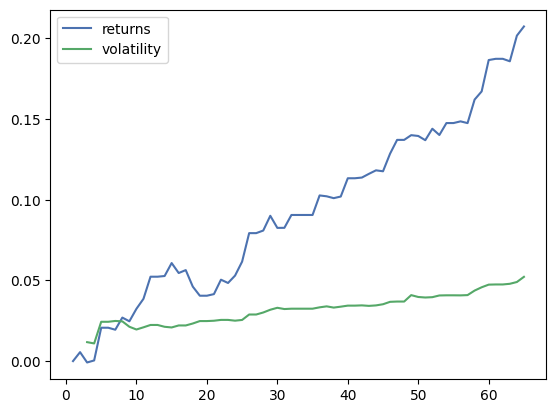

In [ ]:
iterate_over_period(df_stocks, port, 1, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: T

0.2074126242609774
0.052228960136477875


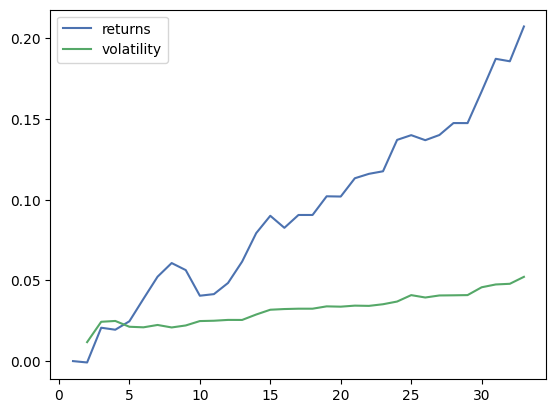

In [ ]:
iterate_over_period(df_stocks, port, 2, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


0.18736945095916474
0.047509055678986924


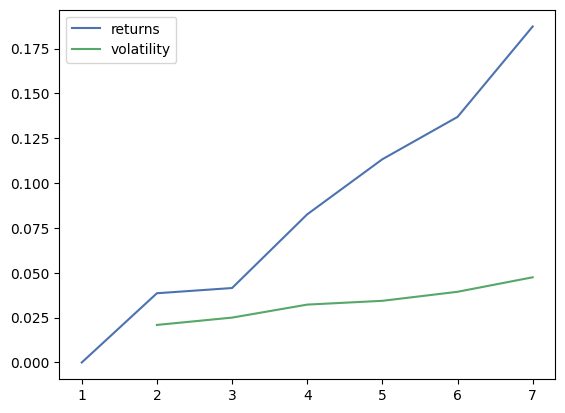

In [ ]:
iterate_over_period(df_stocks, port, 10, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


0.18736945095916474
0.047509055678986924


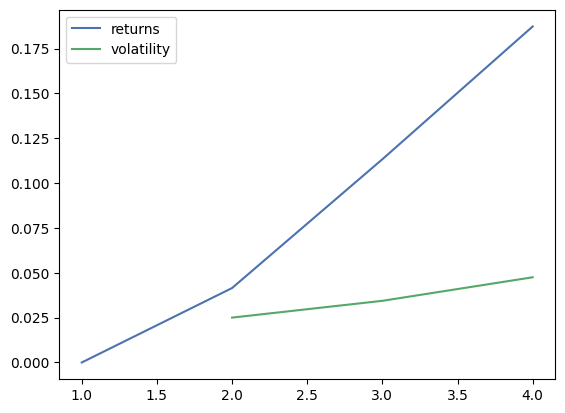

In [ ]:
iterate_over_period(df_stocks, port, 20, '2021-03-01', '2021-06-01')

### Корреляция

In [ ]:
dissimilarity = get_corr_dissimilarity_matrix(stocks_df)

In [ ]:
dissimilarity

array([[0.        , 0.57008736, 0.55526827, ..., 1.32845334, 0.78490798,
        0.74819396],
       [0.        , 0.        , 0.90634194, ..., 1.28402286, 1.14552322,
        0.64987323],
       [0.        , 0.        , 0.        , ..., 1.49163143, 0.56270098,
        1.08317833],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.5485918 ,
        0.89449837],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.28457705],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Ward linkage

##### Формируем портфель

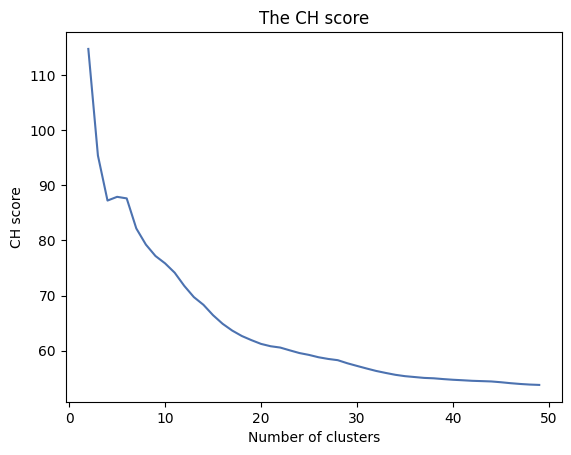

In [ ]:
calinski_harabasz_method(dissimilarity, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 6, linkage='ward')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 6

87.6169131037913

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABBV, ABT, ACN, ADI, ADM, ADP, ADSK, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BKNG, BLK, BMY, BRK-B, BSX, C, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, DG
Cluster 5: ADBE, AEP, AMD, AMGN, AMT, AMZN, APD, BDX, BIIB
Cluster 1: D, DXCM, EQIX, GILD, GIS, KMB, LMT, MRK
Cluster 3: DE, DHR, DIS, DOW, DUK, ECL, EL, ELV, EMR, EOG, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, ICE, IDXX, INTC, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 2: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN
Cluster 4: ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, TMUS, TRV, TS

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'APD', 'GIS', 'HSY', 'MCK', 'SNPS']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
2,ABBV,0.250540,0.068056,3.387517
20,APD,0.094157,0.102910,0.720602
81,GIS,0.202338,0.059678,3.055379
91,HSY,0.215747,0.065454,2.990630
116,MCK,0.348736,0.099169,3.314909
168,SNPS,0.359021,0.146394,2.315807


In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.7%
Annual volatility: 3.3%
Sharpe Ratio: 0.51
(0.016789490626161353, 0.03312198417662066, 0.5068986971502845)
Beta: 1.0730866896083906
Cumulative return: 1.6%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.4%
Annual volatility: 2.6%
Sharpe Ratio: 1.31
(0.034459935789180426, 0.02621610290780431, 1.31445684014774)
Beta: 0.6915107365910914
Cumulative return: 3.28%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.5%
Annual volatility: 4.0%
Sharpe Ratio: 0.36
(0.014520275329628456, 0.04026341834051707, 0.36063195645305424)
Beta: 0.8198290223100837
Cumulative return: 1.38%
Index stats
Expected return: 3.1%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.1%
Annual volatility: 4.1%
Sharpe Ratio: 1.23
(0.0508960238234957, 0.04137320717982517, 1.2301686838605577)
Beta: 0.8041907017384984
Cumulative return: 4.97%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.5%
Annual volatility: 5.7%
Sharpe Ratio: 1.14
(0.0649819129716762, 0.05692344161596796, 1.1415668330469975)
Beta: 0.7986102870812878
Cumulative return: 6.38%
Index stats
Expected return: 7.7%
Volatility: 0.0%


##### Extra (Efficient Frontier)

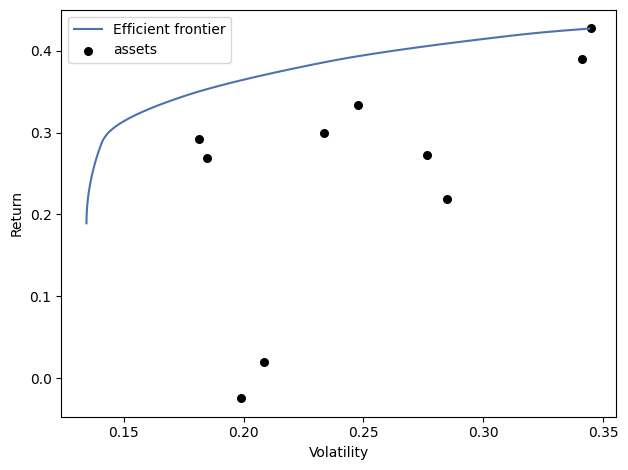

In [ ]:
mu = expected_returns.mean_historical_return(stocks_df[portfolio]) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

fig, ax = plt.subplots()
pplt.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [ ]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

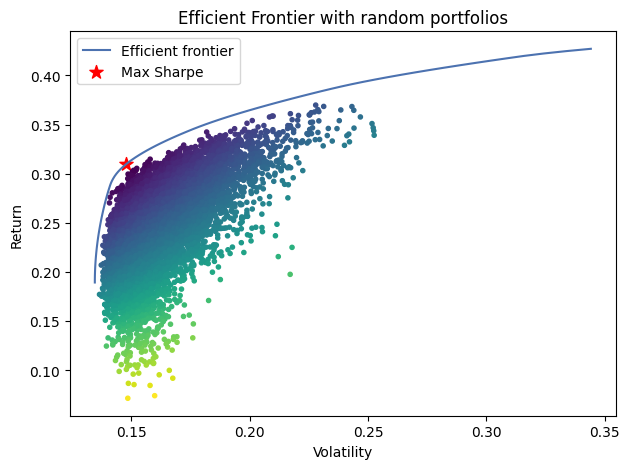

In [ ]:
fig, ax = plt.subplots()
ef_max_sharpe = copy.deepcopy(ef)
pplt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [ ]:
stocks_df[portfolio]

,ABBV,APD,ANET,COST,GIS,HSY,MRK,MCK,PGR,SNPS
Date,,,,,,,,,,
2020-06-01,79.695244,226.643372,58.660000,294.449280,57.995144,129.359299,68.879494,155.529175,72.841507,182.600006
2020-06-02,79.993996,229.165817,57.612499,293.303131,57.885605,130.070435,69.987663,159.687988,73.529572,183.020004
2020-06-03,79.862198,232.117996,57.817501,292.873352,56.105774,127.263863,71.043892,158.249527,73.557465,184.210007
2020-06-04,81.751335,227.923279,57.165001,296.798798,55.457737,126.514771,70.602348,156.096756,73.269234,182.449997
2020-06-05,82.463058,232.230087,58.792500,298.030914,55.676788,128.420593,71.217041,158.151657,76.123741,182.970001
...,...,...,...,...,...,...,...,...,...,...
2021-05-25,105.754684,287.068024,84.574997,380.822357,59.299683,169.149109,69.262474,193.267151,95.186981,255.830002
2021-05-26,105.883926,283.587524,84.614998,381.059509,59.280815,168.742508,69.021156,191.571320,96.282890,254.279999
2021-05-27,103.686859,284.426697,84.279999,382.917236,58.761875,167.919617,67.850395,191.581177,97.016747,254.619995


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


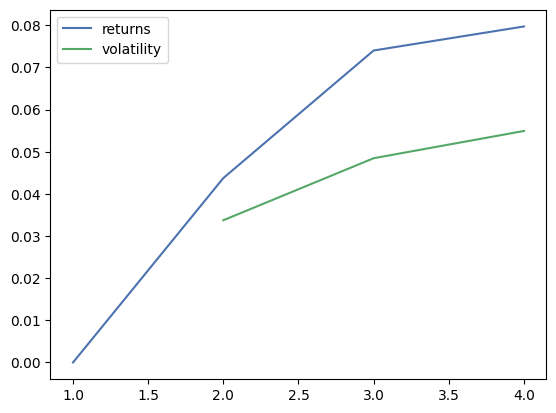

In [ ]:
iterate_over_period(df_stocks, portfolio, 20, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide 

0.08175044964132228
0.05824509793480661


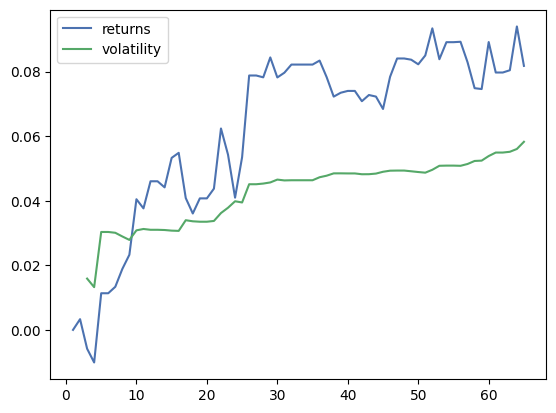

In [ ]:
iterate_over_period(df_stocks, portfolio, 1, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.08175044964132228
0.05824509793480661


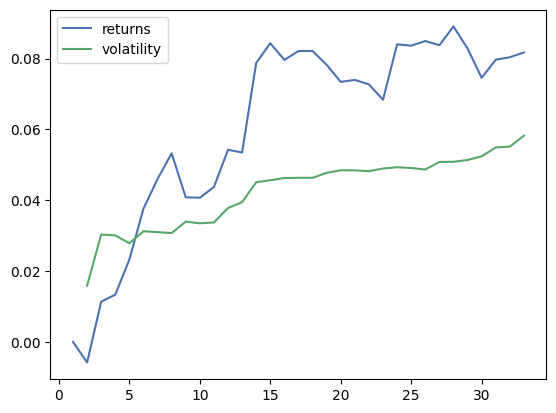

In [ ]:
iterate_over_period(df_stocks, portfolio, 2, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0939541789545766
0.05602240189282889


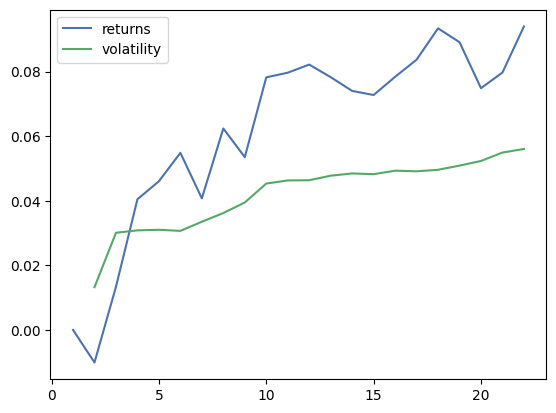

In [ ]:
iterate_over_period(df_stocks, portfolio, 3, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.08175044964132228
0.05824509793480661


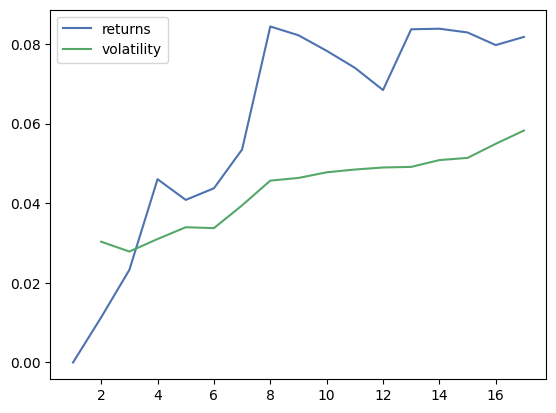

In [ ]:
iterate_over_period(df_stocks, portfolio, 4, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


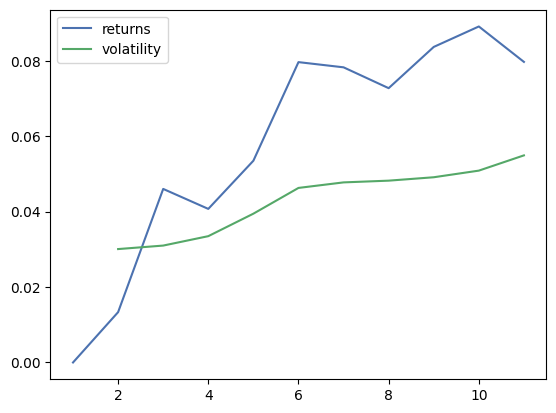

In [ ]:
iterate_over_period(df_stocks, portfolio, 6, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


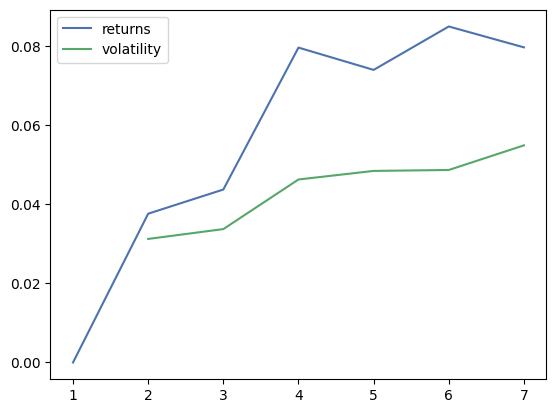

In [ ]:
iterate_over_period(df_stocks, portfolio, 10, '2021-03-01', '2021-06-01')

#### Complete linkage

##### Формируем портфель

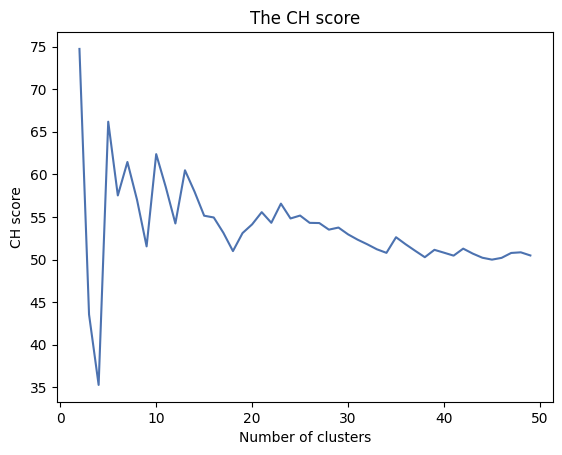

In [ ]:
calinski_harabasz_method(dissimilarity, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 10

62.378531415598296

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, ABBV, ACN, ADI, ADM, ADP, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BKNG, BLK, BMY, BRK-B, C, CAT, CB, CDNS, CI, CMCSA, CME, CMG, COF, COP, CSCO, CSX, CTVA, CVS, CVX
Cluster 0: AAPL, ABT, ADBE, ADSK, AEP, AMD, AMGN, AMZN, APD
Cluster 5: AMT, BDX, BIIB
Cluster 7: BSX, CCI, CHTR, CL, COST, CRM, CTAS, DG
Cluster 2: D, DXCM, EQIX, GILD, GIS
Cluster 9: DE, DHR, DIS, DOW, DUK, ECL, EL, ELV, EMR, EOG, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 1: HUM, INTC, KMB, LMT, MRK
Cluster 4: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, T
Cluster 8: REGN
Cluster 6: SYK, SYY, TDG

In [ ]:
portfolio2 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio2

['ABBV', 'AAPL', 'BIIB', 'COST', 'GIS', 'HSY', 'MRK', 'MCK', 'REGN', 'TMUS']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio2, (0, 0.2))

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio2, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.0%
Annual volatility: 2.7%
Sharpe Ratio: 1.50
(0.03991226129651085, 0.02668052010680948, 1.4959326556128238)
Beta: 0.8766838140389583
Cumulative return: 3.81%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio2, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.3%
Annual volatility: 2.8%
Sharpe Ratio: 1.53
(0.042791540111940356, 0.028001545555159615, 1.528184936350969)
Beta: 0.5957855725825196
Cumulative return: 4.07%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio2, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 0.8%
Annual volatility: 3.2%
Sharpe Ratio: 0.25
(0.007859267615180318, 0.03175872948856727, 0.24746794792309157)
Beta: 0.861588544852904
Cumulative return: 0.75%
Index stats
Expected return: 3.1%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio2, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.3%
Annual volatility: 3.8%
Sharpe Ratio: 2.20
(0.08295249160680489, 0.037770954197907436, 2.196197934851235)
Beta: 0.6773762112190179
Cumulative return: 8.09%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio2, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 9.1%
Annual volatility: 4.9%
Sharpe Ratio: 1.86
(0.091033150880104, 0.04893281381189399, 1.8603702462329434)
Beta: 0.7096876217844744
Cumulative return: 8.95%
Index stats
Expected return: 7.7%
Volatility: 0.0%


##### Extra

0.1403615963015291
0.05348405888520983


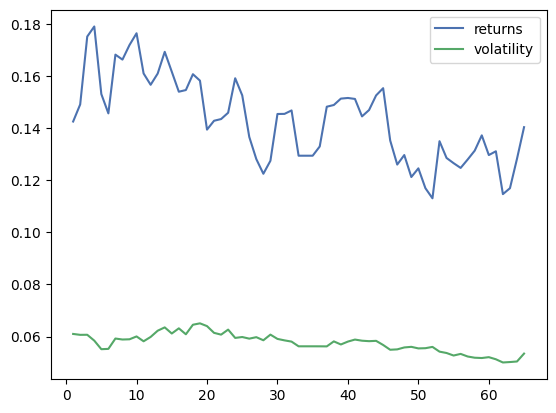

In [ ]:
iterate_over_period(df_stocks, portfolio2, 1, '2021-03-01', '2021-06-01')

0.1403615963015291
0.05348405888520983


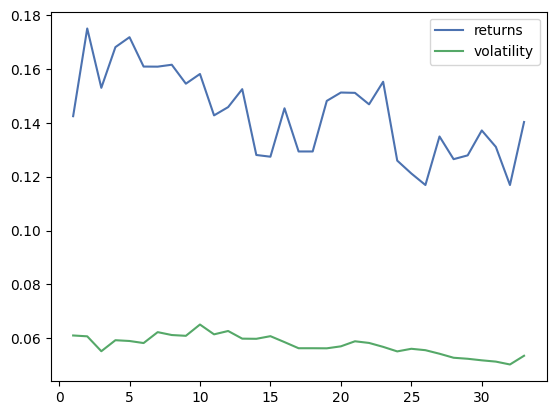

In [ ]:
iterate_over_period(df_stocks, portfolio2, 2, '2021-03-01', '2021-06-01')

0.12824979881927798
0.05045727391340776


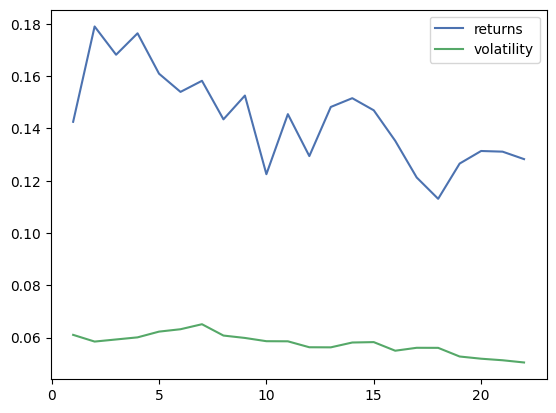

In [ ]:
iterate_over_period(df_stocks, portfolio2, 3, '2021-03-01', '2021-06-01')

0.1403615963015291
0.05348405888520983


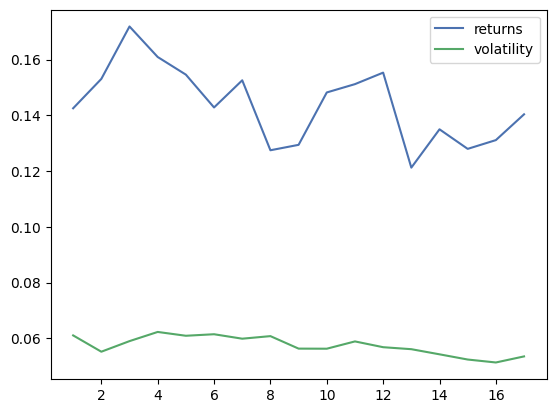

In [ ]:
iterate_over_period(df_stocks, portfolio2, 4, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


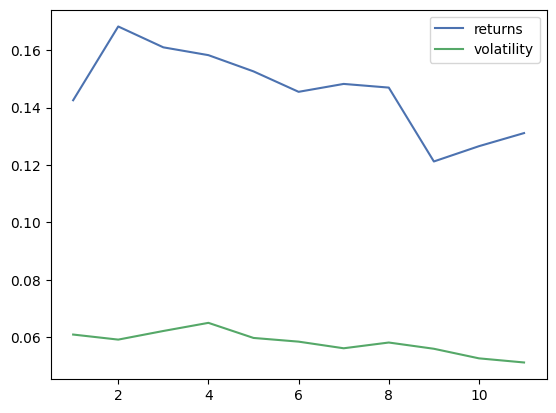

In [ ]:
iterate_over_period(df_stocks, portfolio2, 6, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


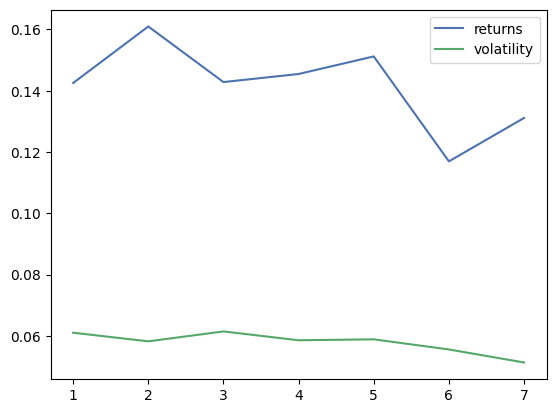

In [ ]:
iterate_over_period(df_stocks, portfolio2, 10, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


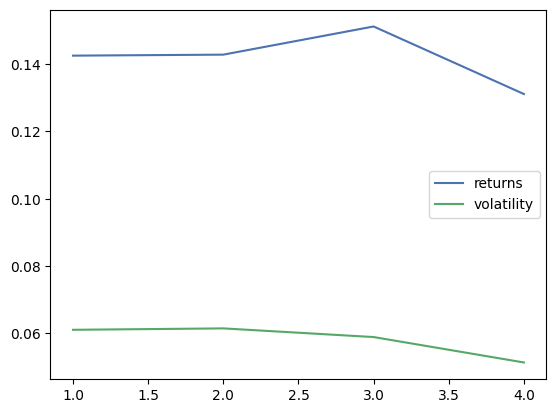

In [ ]:
iterate_over_period(df_stocks, portfolio2, 20, '2021-03-01', '2021-06-01')

#### Average Linkage

##### Формируем портфель

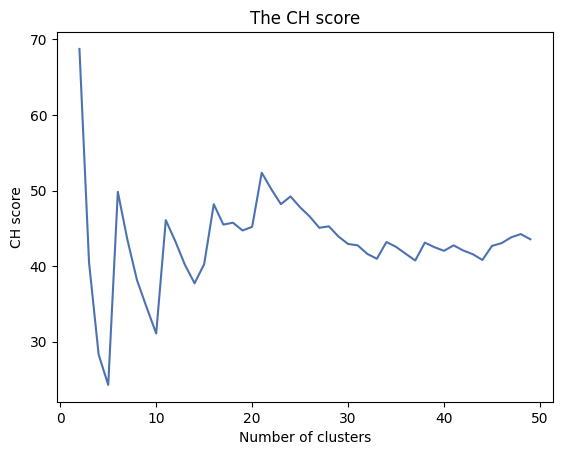

In [ ]:
calinski_harabasz_method(dissimilarity, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 21, linkage='average')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 10

52.35625818580719

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 2: A, AAPL, ABBV, ABT, ACN, ADI, ADM, ADP, ADSK, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BMY
Cluster 3: ADBE, AEP, AMD, AMGN, AMZN, APD
Cluster 12: AMT
Cluster 11: BDX, BIIB
Cluster 8: BKNG, BLK, BRK-B, C, CAT, CB, CI, CMCSA, CME, COF, COP, CSCO, CSX, CTVA, CVS, CVX, DE, DIS, DOW
Cluster 13: BSX, CCI
Cluster 18: CDNS, CHTR, CL, CMG, COST, CTAS
Cluster 6: CRM, DG
Cluster 16: D
Cluster 10: DHR, DUK, ECL, EW, FDX
Cluster 1: DXCM, EQIX
Cluster 20: EL, ELV, EMR, EOG, ETN, EXC, F, FCX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 17: GILD, GIS
Cluster 0: HUM, INTC
Cluster 4: KMB, LMT
Cluster 14: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU
Cluster 19: MRK
Cluster 9: NEE, NEM, NFLX, NKE, NOC, NOW
Cluster 5: NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PS

In [ ]:
portfolio3 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio3

['ABBV',
 'APD',
 'AMT',
 'BIIB',
 'DE',
 'BSX',
 'COST',
 'DG',
 'D',
 'DHR',
 'DXCM',
 'HSY',
 'GIS',
 'HUM',
 'LMT',
 'MCK',
 'MRK',
 'NOC',
 'PGR',
 'REGN',
 'SNPS']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio3, (0, 0.2))

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio3, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.06
(0.03106580857685229, 0.029169897035403857, 1.0649954828139208)
Beta: 0.8674257854675003
Cumulative return: 2.96%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio3, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.5%
Annual volatility: 3.8%
Sharpe Ratio: 2.21
(0.0847878035029783, 0.03835615720666419, 2.2105395763746336)
Beta: 0.6474535077864917
Cumulative return: 8.27%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio3, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 12.7%
Annual volatility: 4.9%
Sharpe Ratio: 2.60
(0.12713870040071001, 0.04891566946791332, 2.599140557283138)
Beta: 0.6888359354098026
Cumulative return: 12.5%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio3, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.3%
Annual volatility: 2.6%
Sharpe Ratio: 2.03
(0.05275634034112228, 0.02602167735099229, 2.027399680255835)
Beta: 0.5563223150899226
Cumulative return: 5.02%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio3, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.4%
Annual volatility: 3.1%
Sharpe Ratio: 1.44
(0.04433256365335722, 0.030744573886142993, 1.4419638345789052)
Beta: 0.828326837355027
Cumulative return: 4.23%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra

0.20414355456886407
0.05704616176308251


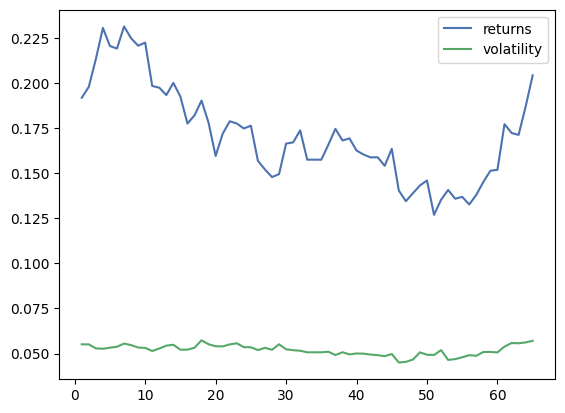

In [ ]:
iterate_over_period(df_stocks, portfolio3, 1, '2021-03-01', '2021-06-01')

0.20414355456886407
0.05704616176308251


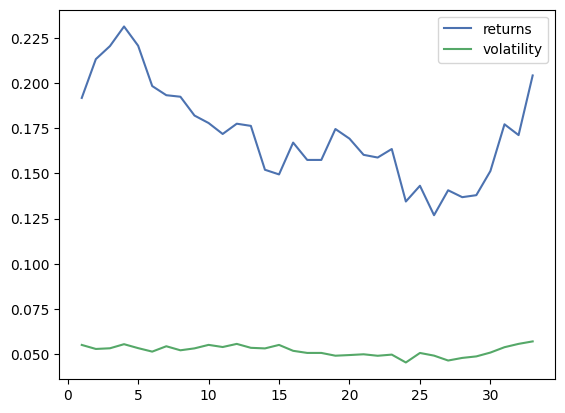

In [ ]:
iterate_over_period(df_stocks, portfolio3, 2, '2021-03-01', '2021-06-01')

0.18682155975389506
0.05614441367458281


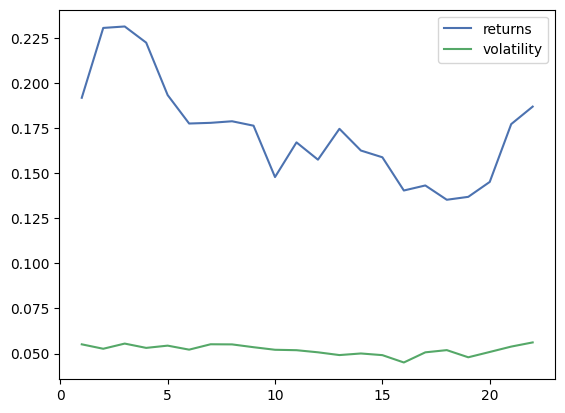

In [ ]:
iterate_over_period(df_stocks, portfolio3, 3, '2021-03-01', '2021-06-01')

0.20414355456886407
0.05704616176308251


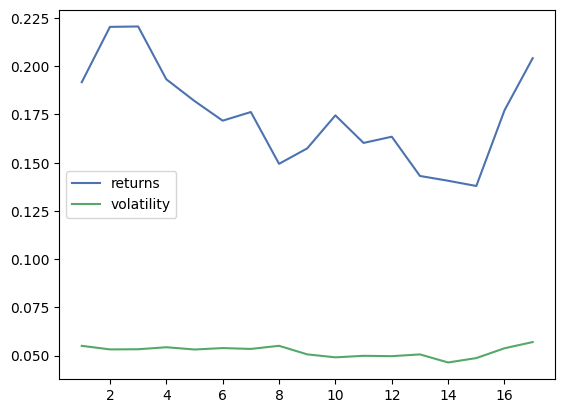

In [ ]:
iterate_over_period(df_stocks, portfolio3, 4, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


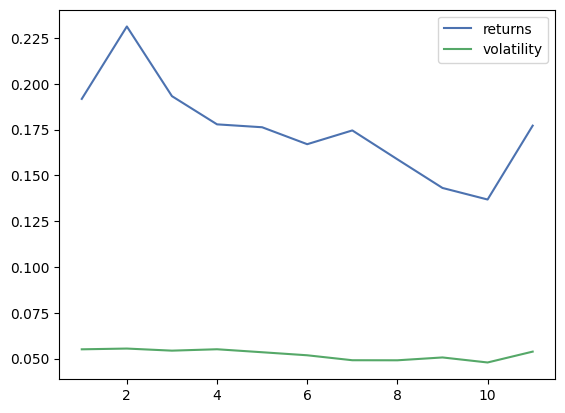

In [ ]:
iterate_over_period(df_stocks, portfolio3, 6, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


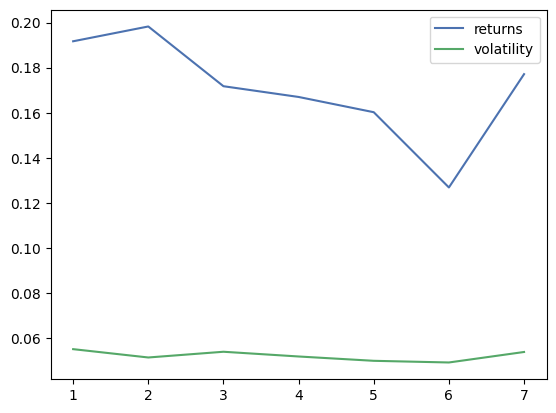

In [ ]:
iterate_over_period(df_stocks, portfolio3, 10, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


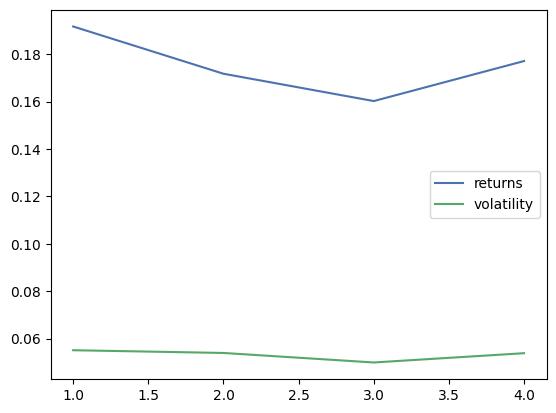

In [ ]:
iterate_over_period(df_stocks, portfolio3, 20, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


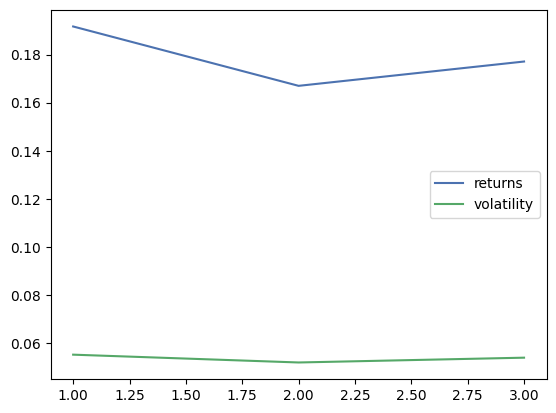

In [ ]:
iterate_over_period(df_stocks, portfolio3, 30, '2021-03-01', '2021-06-01')

#### Single Linkage

##### Формируем портфель

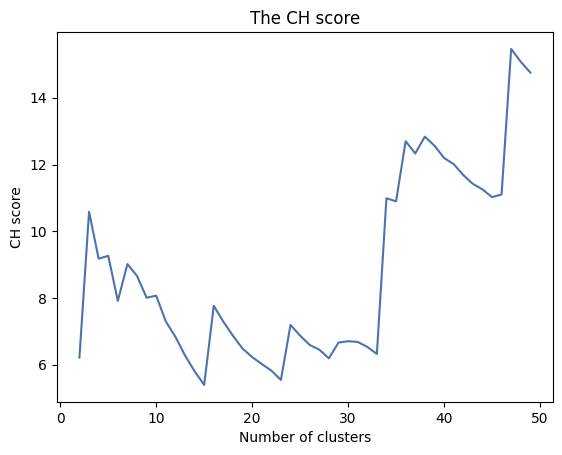

In [ ]:
calinski_harabasz_method(dissimilarity, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 48, linkage='average')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 10

44.23660150306052

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 4: A, ABBV, ACN, ADI, ADM, ADP, AIG, AJG, AMAT
Cluster 14: AAPL, ABT, ADSK
Cluster 36: ADBE
Cluster 31: AEP
Cluster 7: AMD, AMZN
Cluster 43: AMGN
Cluster 25: AMT
Cluster 3: ANET, AON, APH, ATVI, AVGO, AXP, BA, BAC
Cluster 26: APD
Cluster 0: AZO, BMY
Cluster 5: BDX, BIIB
Cluster 19: BKNG, BLK, BRK-B, C, CAT, CB, CI, CME
Cluster 27: BSX, CCI
Cluster 40: CDNS, CMG
Cluster 6: CHTR, CL, COST, CTAS
Cluster 9: CMCSA, COF, CSX, CTVA, DE, DIS, DOW
Cluster 13: COP, CSCO, CVS, CVX
Cluster 28: CRM
Cluster 33: D
Cluster 29: DG
Cluster 18: DHR, DUK
Cluster 45: DXCM
Cluster 35: ECL
Cluster 22: EL, ELV, EMR, ETN, EXC, F, FCX, FISV, GE
Cluster 1: EOG, FTNT, GD, HES
Cluster 47: EQIX
Cluster 42: EW, FDX
Cluster 8: GILD, GIS
Cluster 16: GM, GOOG, GOOGL, GS, HCA, HLT, HON, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 23: HD, HSY, IBM
Cluster 44: HUM
Cluster 37: INTC
Cluster 12: KMB
Cluster 11: KO, LHX, LIN, LOW, MA, MCD, MCO, MDLZ, META, MMC
Cluster 30: LLY
Cluster 32: LMT
Cluster 10: LR

In [ ]:
portfolio4 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio4, (0, 0.2))

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio4, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.7%
Annual volatility: 3.3%
Sharpe Ratio: 0.80
(0.02683899635725448, 0.03345878875770511, 0.8021508654007632)
Beta: 0.8763123011254539
Cumulative return: 2.55%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio4, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.5%
Annual volatility: 4.7%
Sharpe Ratio: 0.96
(0.044777183473238454, 0.04670041511412007, 0.9588176756848544)
Beta: 0.8656811512441704
Cumulative return: 4.35%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio4, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.5%
Annual volatility: 5.8%
Sharpe Ratio: 1.12
(0.06459747930624442, 0.057789907339944754, 1.1177986309314296)
Beta: 0.872943300255242
Cumulative return: 6.34%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio4, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.6%
Annual volatility: 3.4%
Sharpe Ratio: 0.45
(0.015507931377130147, 0.03416414814219472, 0.45392413452208824)
Beta: 0.8944275295901456
Cumulative return: 1.47%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio4, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.4%
Annual volatility: 3.5%
Sharpe Ratio: 0.70
(0.024447177954007634, 0.034792326040844035, 0.7026600614545909)
Beta: 0.9205018057748704
Cumulative return: 2.33%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra

In [ ]:
iterate_over_period(df_stocks, portfolio4, (0, 0.2), 1, '2021-03-01', '2021-06-01')

NameError: ignored

0.40018511346182783
0.06111086428913276


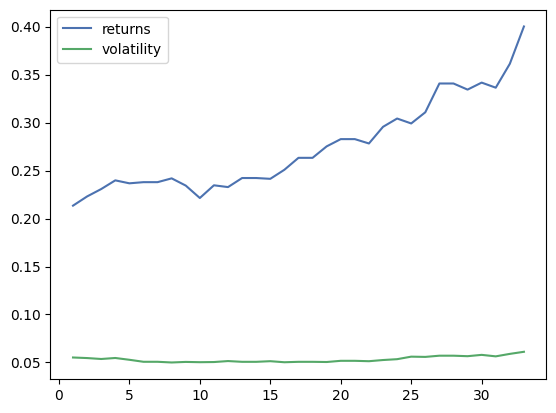

In [ ]:
iterate_over_period(df_stocks, portfolio4, 2, '2021-03-01', '2021-06-01')

0.39142296329225124
0.06043734643378408


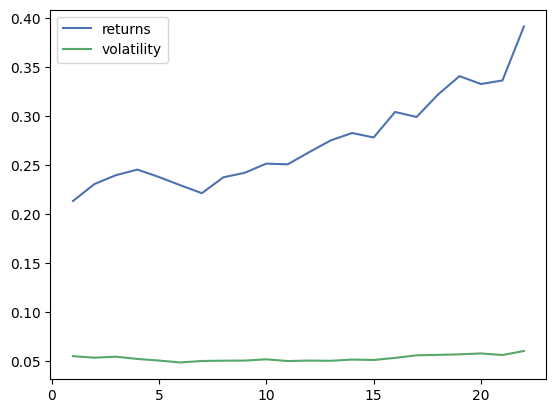

In [ ]:
iterate_over_period(df_stocks, portfolio4, 3, '2021-03-01', '2021-06-01')

0.40018511346182783
0.06111086428913276


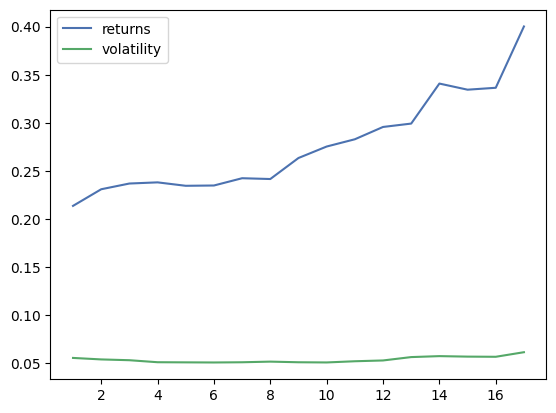

In [ ]:
iterate_over_period(df_stocks, portfolio4, 4, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


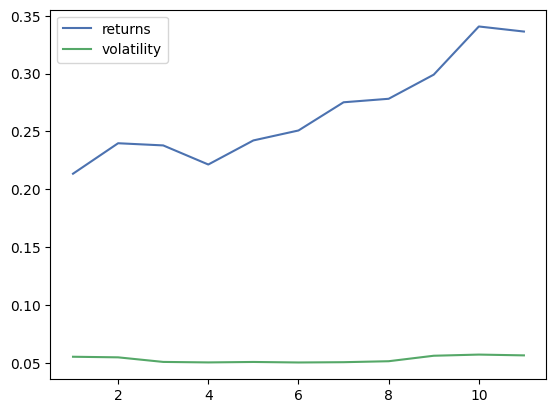

In [ ]:
iterate_over_period(df_stocks, portfolio4, 6, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


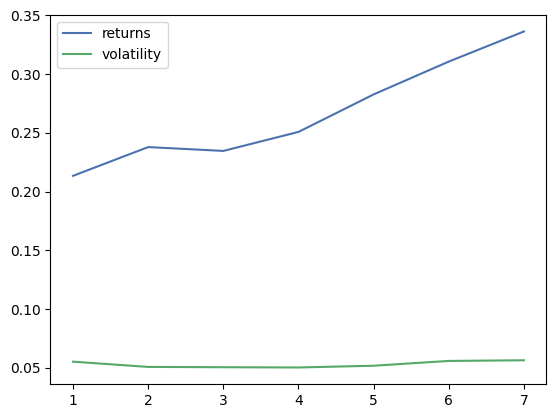

In [ ]:
iterate_over_period(df_stocks, portfolio4, 10, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


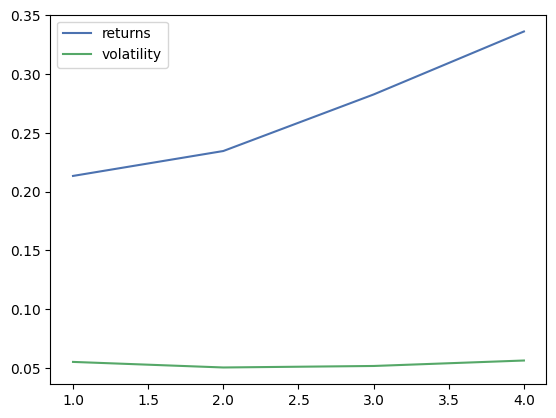

In [ ]:
iterate_over_period(df_stocks, portfolio4, 20, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


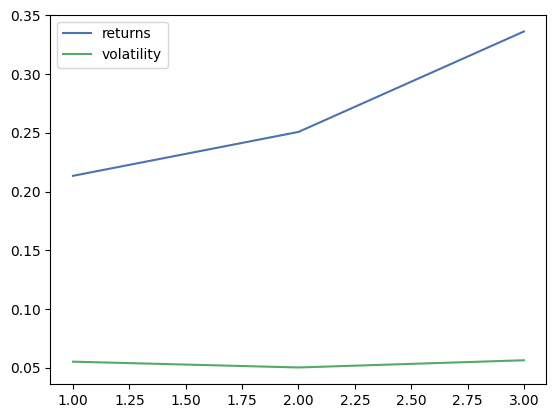

In [ ]:
iterate_over_period(df_stocks, portfolio4, 30, '2021-03-01', '2021-06-01')

### Мультипликаторы

In [ ]:
tickers = yf.Tickers(stock_tickers)

In [ ]:
tickers

yfinance.Tickers object <AAPL,MSFT,AMZN,NVDA,GOOGL,BRK-B,GOOG,TSLA,UNH,META,XOM,JNJ,JPM,V,PG,MA,CVX,HD,LLY,ABBV,MRK,AVGO,PEP,KO,PFE,TMO,COST,WMT,MCD,CSCO,BAC,CRM,DIS,ACN,ABT,LIN,ADBE,VZ,DHR,TXN,CMCSA,NEE,NKE,PM,AMD,NFLX,WFC,BMY,RTX,ORCL,UPS,T,QCOM,AMGN,INTC,COP,HON,INTU,LOW,UNP,SBUX,BA,IBM,ELV,CAT,PLD,SPGI,MS,GS,LMT,MDT,DE,GILD,GE,BLK,BKNG,AMAT,CVS,SYK,AMT,AXP,ADI,MDLZ,NOW,ISRG,C,TJX,ADP,TMUS,REGN,PGR,MMC,VRTX,PYPL,CB,MO,ZTS,CI,SCHW,SO,TGT,DUK,FISV,SLB,BSX,BDX,EOG,MU,CME,LRCX,NOC,HUM,AON,EQIX,ITW,CSX,CL,APD,ETN,WM,ATVI,MPC,ICE,FCX,CDNS,CCI,SNPS,MMM,HCA,EL,ORLY,FDX,SHW,VLO,KLAC,PXD,GIS,GD,MRNA,EW,F,MCK,PSA,PSX,USB,GM,PNC,DG,SRE,D,AEP,EMR,AZO,MSI,CMG,MCO,NSC,OXY,APH,ROP,KMB,ADM,TFC,NXPI,DXCM,MCHP,MAR,CTVA,FTNT,EXC,ADSK,MSCI,AJG,A,ECL,BIIB,PH,HES,TRV,TEL,MNST,SYY,NEM,IDXX,MET,ANET,DOW,TT,CTAS,O,JCI,XEL,TDG,HSY,AIG,LHX,HLT,CHTR,NUE,COF>

In [ ]:
# tickers.tickers['MSFT'].info

In [ ]:
indicators = pd.DataFrame(columns=['ticker', 'returnOnAssets', 
                                   'revenueGrowth', 'ebitdaMargins'])
indicators

,ticker,returnOnAssets,revenueGrowth,ebitdaMargins


In [ ]:
for ticker in stock_tickers:
    try:
        indicators.loc[ticker] = [
            ticker,
            tickers.tickers[ticker].info['returnOnAssets'],
            tickers.tickers[ticker].info['revenueGrowth'],
            tickers.tickers[ticker].info['ebitdaMargins'],
        ]
    except KeyError:
        continue
    
    indicators = indicators.reset_index(drop=True)

In [ ]:
indicators.head()

,ticker,returnOnAssets,revenueGrowth,ebitdaMargins
0,AAPL,0.19570,-0.055,0.32329
1,MSFT,0.14829,0.071,0.48210
2,AMZN,0.01906,0.094,0.10896
3,NVDA,0.08166,-0.208,0.26399
4,GOOGL,0.12415,0.026,0.30742


In [ ]:
indicators.shape

(164, 4)

In [ ]:
data = indicators.copy()
data = data.drop('ticker', axis=1)

#### Ward Linkage

##### Формируем портфель

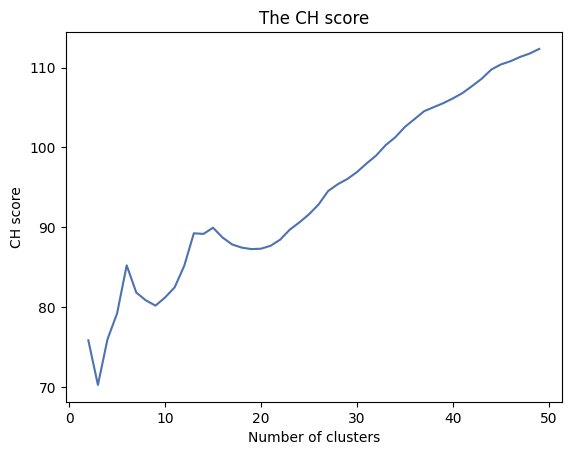

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
model = AgglomerativeClustering(n_clusters = 15, linkage='ward')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

89.94282091944562

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, AMZN, CMG, INTC, LIN, MSFT, REGN, SRE, TDG
Cluster 1: AAPL, BKNG, BRK-B, CB, CHTR, COF, CTAS, DXCM, ELV, GILD, GOOGL, IBM, JNJ, LLY, MDLZ, MMM, NOC, NOW, PSX
Cluster 10: ABBV, ADBE, ATVI, AVGO, AZO, CDNS, D, DHR, ECL, EQIX, FCX, GS, HCA, HES, ISRG, MNST, MRNA, MS, O, ORCL, PXD
Cluster 5: ABT, COP, MAR, ROP, SBUX, TEL
Cluster 9: ACN, ADI, ADSK, AIG, AMD, APD, AXP, CSCO, EMR, F, FISV, GE, ITW, JPM, KLAC, KMB, MCD, NEM, NFLX, PLD, PM, QCOM, SCHW, SPGI
Cluster 2: ADM, ADP, AJG, BA, CAT, CVS, EW, EXC, GM, MPC, MRK, MSCI, NKE, ORLY, PSA
Cluster 0: AEP, AMT, AON, APH, BAC, BDX, CCI, CI, CMCSA, CRM, CSX, CTVA, CVX, DIS, DOW, FDX, GIS, HUM, INTU, LOW, LRCX, MA, MCHP, MCK, MCO, MET, META, NEE, NUE, NXPI, PEP, PGR, PYPL, SLB, SYK
Cluster 4: AMAT, AMGN, ANET, EOG, GOOG, IDXX, LHX, LMT, MO, NSC, PH
Cluster 14: BIIB, BLK, BMY, BSX, CME, FTNT, HD, HON, JCI, PNC, SNPS, T
Cluster 7: C
Cluster 11: CL, COST, DG, ETN, HLT, MSI, MU, NVDA, OXY, SO
Cluster 6: DE, SHW, SYY
Cluster 8: DUK, EL, HS

In [ ]:
portfolio5 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio5

['REGN',
 'LLY',
 'ABBV',
 'TEL',
 'MCD',
 'AJG',
 'MCK',
 'ANET',
 'SNPS',
 'C',
 'COST',
 'DE',
 'HSY',
 'MMC',
 'PG']

In [ ]:
#Годовая доходность
mu = expected_returns.mean_historical_return(stocks_df[portfolio5]) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio5])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0, 0.2), verbose=True)
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 04 10:36:39 AM: Your problem has 16 variables, 5 constraints, and 0 parameters.
(CVXPY) May 04 10:36:39 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 10:36:39 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 10:36:39 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 10:36:39 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 04 10:36:39 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 62.2%
Annual volatility: 15.0%
Sharpe Ratio: 4.02


(0.622102918804897, 0.14960267627192314, 4.024680131460304)

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio5, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: -0.0%
Annual volatility: 3.0%
Sharpe Ratio: -0.00
(-5.556547678252453e-06, 0.03016541046118839, -0.00018420262125727258)
Beta: 1.0371972495808497
Cumulative return: -0.01%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio5, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 4.6%
Sharpe Ratio: 0.83
(0.038742369299617926, 0.046451899201275494, 0.8340319764267922)
Beta: 0.9455391638254381
Cumulative return: 3.78%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio5, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 7.2%
Annual volatility: 5.3%
Sharpe Ratio: 1.37
(0.07247267911065915, 0.05304736705552655, 1.366188052930119)
Beta: 0.9081360290815437
Cumulative return: 7.13%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio5, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 3.6%
Sharpe Ratio: 1.06
(0.038501391250642995, 0.03629640501086237, 1.060749438935364)
Beta: 0.940941970556206
Cumulative return: 3.66%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio5, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.43
(0.03770116060780224, 0.02640190942973193, 1.4279709847555915)
Beta: 0.8270962667117913
Cumulative return: 3.6%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Complete Linkage

##### Формируем портфель

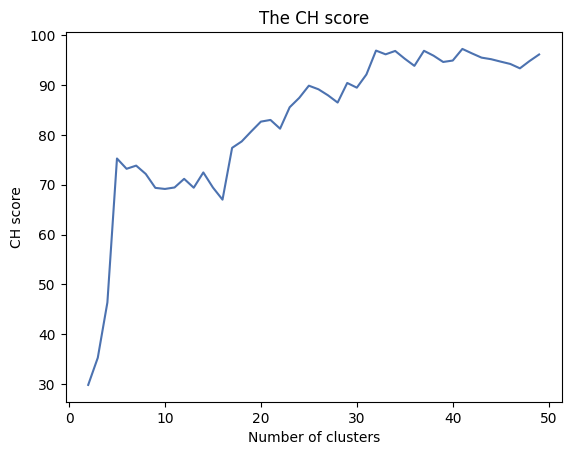

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
model = AgglomerativeClustering(n_clusters = 5, linkage='complete')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

75.27736606705885

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ACN, ADI, ADSK, AIG, AMD, APD, AXP, BKNG, BRK-B, CB, CHTR, CL, CME, CMG, COF, COST, CRM, CSCO, CTAS, DG, DUK, DXCM, EL, ELV, EMR, ETN, F, FISV, GE, GILD, GOOG, GOOGL, HLT, HON, HSY, IBM, INTC, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LLY, LOW, MCD, MDLZ, MMM, MSI, MU, NEE, NEM, NFLX, NOC, NOW, NSC, NVDA, OXY, PFE, PGR, PH, PLD, PM, PSX, QCOM, RTX, SCHW, SNPS, SO, SPGI, T
Cluster 4: ABBV, ADBE, ADM, ADP, AJG, AMT, AON, ATVI, AVGO, AZO, BA, BAC, BDX, CAT, CCI, CDNS, CI, CMCSA, CSX, CTVA, CVS, D, DHR, DIS, ECL, EQIX, EW, EXC, FCX, FDX, GIS, GM, GS, HCA, HES, INTU, ISRG, MA, MCHP, MCK, MCO, MET, META, MNST, MPC, MRK, MRNA, MS, MSCI, NKE, NXPI, O, ORCL, ORLY, PEP, PSA, PXD, PYPL, SLB, SYK
Cluster 2: ABT, AEP, AMZN, APH, BIIB, BLK, BMY, BSX, COP, CVX, DOW, FTNT, GD, HD, HUM, ICE, LIN, LRCX, MAR, MDT, MMC, MSFT, NUE, PG, PNC, REGN, ROP, SBUX, SRE, TDG, TEL
Cluster 1: AMAT, AMGN, ANET, DE, EOG, IDXX, LHX, LMT, MO, SHW, SYY
Cluster 3: C


In [ ]:
portfolio6 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio6

['LLY', 'ABBV', 'REGN', 'ANET', 'C']

In [ ]:
#Годовая доходность
mu = expected_returns.mean_historical_return(stocks_df[portfolio6]) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio6])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0, 0.2), verbose=True)
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 04 12:10:47 PM: Your problem has 6 variables, 5 constraints, and 0 parameters.
(CVXPY) May 04 12:10:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 12:10:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 12:10:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 12:10:47 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 04 12:10:47 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing 

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 31.3%
Annual volatility: 19.8%
Sharpe Ratio: 1.48


(0.3134840838228068, 0.19791623412232495, 1.4828701906353712)

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio6, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.3%
Annual volatility: 5.4%
Sharpe Ratio: 1.18
(0.0631299206499333, 0.053610545111858254, 1.177565356185297)
Beta: 0.8992369269935031
Cumulative return: 6.01%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio6, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.4%
Annual volatility: 6.0%
Sharpe Ratio: 1.40
(0.08362616091655026, 0.059889640799606535, 1.3963376604038618)
Beta: 0.7837921019707254
Cumulative return: 8.14%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio6, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 13.0%
Annual volatility: 7.0%
Sharpe Ratio: 1.86
(0.13046683498399586, 0.07022294140433874, 1.8578947616673736)
Beta: 0.7683138560050512
Cumulative return: 12.82%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio6, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.9%
Annual volatility: 2.9%
Sharpe Ratio: 0.64
(0.018699155085625585, 0.029092284869917776, 0.6427530587314242)
Beta: 0.745588126948388
Cumulative return: 1.78%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio6, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.3%
Annual volatility: 3.9%
Sharpe Ratio: 1.12
(0.04319825293922788, 0.03860076947189847, 1.1191034150414125)
Beta: 0.773381064443284
Cumulative return: 4.11%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Average Linkage

##### Формируем портфель

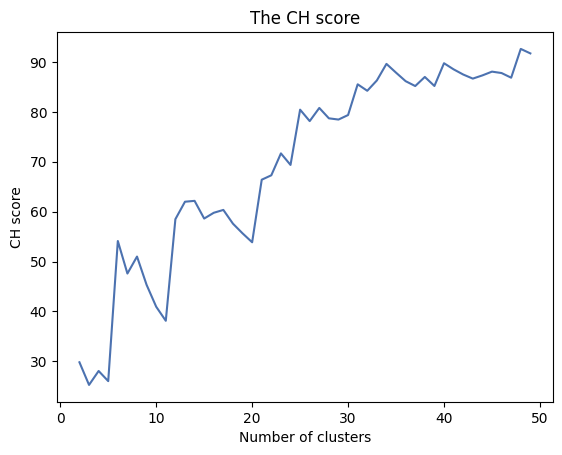

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
model = AgglomerativeClustering(n_clusters = 14, linkage='average')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

62.15739962668481

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 5: A, ACN, ADI, ADSK, AEP, AIG, AMD, AMZN, APD, APH, AXP, BIIB, BKNG, BLK, BMY, BSX, CME, CMG, CSCO, CVX, DOW, ELV, EMR, F, FISV, FTNT, GE, HD, HON, HUM, INTC, ITW, JCI, KLAC, KMB, LLY, LRCX, MMM, MSFT, NFLX, NUE, PLD, PM, PNC, QCOM, REGN, SNPS, T, TDG
Cluster 2: AAPL, AMAT, AMGN, ANET, CB, CHTR, COF, CTAS, DXCM, EOG, GILD, GOOG, GOOGL, IBM, IDXX, JNJ, LHX, LMT, MDLZ, MO, NOC, NOW, NSC, PH, PSX
Cluster 4: ABBV, ADBE, ADM, ADP, AMT, AON, ATVI, AVGO, AZO, BA, BAC, BDX, CAT, CCI, CDNS, CI, CMCSA, CRM, CSX, CTVA, D, DHR, DIS, ECL, EQIX, EW, EXC, FCX, FDX, GIS, GM, GS, HCA, HES, INTU, ISRG, JPM, LOW, MA, MCD, MCK, MCO, MET, META, MNST, MRNA, MS, MSCI, NEE, NEM, NKE, NXPI, O, ORCL, ORLY, PEP, PGR, PSA, PXD, PYPL, SCHW, SLB, SPGI, SYK
Cluster 0: ABT, COP, LIN, MAR, SBUX, SRE
Cluster 6: AJG, CVS, MPC, MRK
Cluster 1: BRK-B, GD, MDT, MMC
Cluster 7: C
Cluster 12: CL, COST, DG, ETN, HLT, MSI, MU, NVDA, OXY, SO
Cluster 3: DE, SYY
Cluster 11: DUK, EL, HSY, KO, PFE
Cluster 13: ICE, PG
Cluster

In [ ]:
portfolio7 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio7

['LLY',
 'ANET',
 'ABBV',
 'LIN',
 'AJG',
 'MMC',
 'C',
 'COST',
 'DE',
 'HSY',
 'PG',
 'TEL',
 'RTX',
 'SHW']

In [ ]:
#Годовая доходность
mu = expected_returns.mean_historical_return(stocks_df[portfolio7]) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio7])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0, 0.2), verbose=True)
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 04 12:16:56 PM: Your problem has 15 variables, 5 constraints, and 0 parameters.
(CVXPY) May 04 12:16:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 12:16:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 12:16:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 12:16:56 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 04 12:16:56 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 64.4%
Annual volatility: 15.4%
Sharpe Ratio: 4.06


(0.644177906841711, 0.15359556107835787, 4.063775687653383)

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio7, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: -0.7%
Annual volatility: 3.1%
Sharpe Ratio: -0.22
(-0.006630321505669259, 0.030687121553341773, -0.21606202113626485)
Beta: 1.0120958415766415
Cumulative return: -0.64%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio7, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.2%
Annual volatility: 4.6%
Sharpe Ratio: 0.71
(0.03246206906744857, 0.04578497013289955, 0.7090114719573097)
Beta: 0.8826370625076615
Cumulative return: 3.16%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio7, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 7.4%
Annual volatility: 5.3%
Sharpe Ratio: 1.39
(0.07373757620188795, 0.05304243242556528, 1.3901620425376282)
Beta: 0.8698330263657491
Cumulative return: 7.25%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio7, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 3.5%
Sharpe Ratio: 1.12
(0.0389409438571211, 0.03473548436463901, 1.1210709903548453)
Beta: 0.8555698731657768
Cumulative return: 3.7%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio7, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.4%
Annual volatility: 2.8%
Sharpe Ratio: 1.62
(0.04447432781184075, 0.027507959257900363, 1.6167803432771044)
Beta: 0.8635220377221793
Cumulative return: 4.25%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Single Linkage

##### Формируем портфель

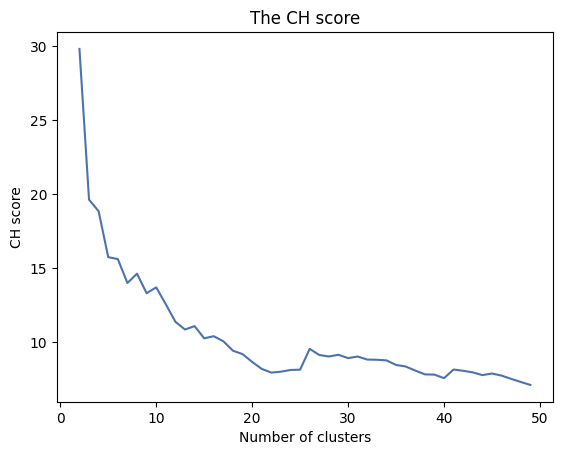

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
model = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

13.694428456476835

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEP, AIG, AJG, AMD, AMGN, AMT, AMZN, ANET, AON, APD, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BDX, BIIB, BKNG, BLK, BMY, BSX, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CME, CMG, COF, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, D, DG, DHR, DIS, DOW, DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GE, GILD, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, IDXX, INTC, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LMT, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MET, META, MMM, MNST, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, SBUX, SCHW, SLB, SNPS, SO, SPGI, SRE, SYK, T, TDG, TEL
Cluster 4: AMAT, MO
Cluster 8: BRK-B
Cluster 7: C
Cluster 6: COP
Cluster 2: DE, SYY
Cluster 1: GD, MDT, MMC
Cluster 3: ICE, PG
Cluster 9: RTX
Cluster 5

In [ ]:
portfolio8 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio8

['ABBV', 'AMAT', 'BRK-B', 'C', 'COP', 'DE', 'MMC', 'PG', 'RTX', 'SHW']

In [ ]:
#Годовая доходность
mu = expected_returns.mean_historical_return(stocks_df[portfolio8]) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio8])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0, 0.2), verbose=True)
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 04 12:21:59 PM: Your problem has 11 variables, 5 constraints, and 0 parameters.
(CVXPY) May 04 12:21:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 12:21:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 12:21:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 12:21:59 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 04 12:21:59 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 85.5%
Annual volatility: 18.9%
Sharpe Ratio: 4.43


(0.85519396163951, 0.18863170688082412, 4.427643557120428)

##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio8, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: -1.4%
Annual volatility: 3.2%
Sharpe Ratio: -0.44
(-0.014106775730068967, 0.031843739251727635, -0.4429999761822452)
Beta: 1.0780789492511984
Cumulative return: -1.35%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio8, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.3%
Annual volatility: 4.9%
Sharpe Ratio: 0.25
(0.012537144123585447, 0.0493574439248635, 0.2540071593389369)
Beta: 0.9810991669601618
Cumulative return: 1.22%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio8, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.1%
Annual volatility: 5.8%
Sharpe Ratio: 0.54
(0.03109290459095908, 0.05800494019575512, 0.5360389043765362)
Beta: 0.9621916405341173
Cumulative return: 3.06%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio8, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.7%
Annual volatility: 3.9%
Sharpe Ratio: 0.70
(0.027257937312609178, 0.038758263228803026, 0.7032806695103037)
Beta: 0.9753421258841677
Cumulative return: 2.59%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio8, 
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.0%
Annual volatility: 3.2%
Sharpe Ratio: 0.61
(0.019614939896059627, 0.03200311637984876, 0.6129071826395778)
Beta: 0.9696844971857407
Cumulative return: 1.87%
Index stats
Expected return: 3.1%
Volatility: 0.0%


### Просадки

In [ ]:
# https://drive.google.com/file/d/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl/view?usp=share_link

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl' -O drawdowns-2020.csv

--2023-05-07 12:12:10--  https://docs.google.com/uc?export=download&id=1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl
Resolving docs.google.com (docs.google.com)... 142.251.2.113, 142.251.2.101, 142.251.2.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rk5uere64kau92cngtacmg60iidv0vfp/1683461475000/11915959673283641640/*/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl?e=download&uuid=2a542845-8f87-4609-a3e4-b6f6566612cd [following]
--2023-05-07 12:12:10--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rk5uere64kau92cngtacmg60iidv0vfp/1683461475000/11915959673283641640/*/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl?e=download&uuid=2a542845-8f87-4609-a3e4-b6f6566612cd
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:402

In [ ]:
drawdowns_2020 = pd.read_csv('drawdowns-2020.csv', 
                             sep=';', 
                             decimal=',', 
                             index_col=0, 
                             header=0, 
                             names=['Ticker', 
                                    'return', 
                                    'risk', 
                                    'cum_drawdown', 
                                    'max_drawdown'])
drawdowns_2020

,Ticker,return,risk,cum_drawdown,max_drawdown
1,AAPL,0.591955,0.029405,14.764558,58.965542
2,MSFT,0.343873,0.027716,14.901497,41.541118
3,ATVI,0.446354,0.024419,17.671408,43.941842
4,EA,0.289448,0.022881,24.337867,40.837019
5,HPQ,0.179479,0.034794,36.158227,46.685645
...,...,...,...,...,...
64,COP,-0.486219,0.046097,66.543214,65.899519
65,CVX,-0.355573,0.038922,69.627463,55.348761
66,EOG,-0.518536,0.048654,65.799384,66.670400
67,SLB,-0.610582,0.049686,55.099437,70.480157


In [ ]:
drawdowns_2020.isna().sum().sum()

0

In [ ]:
drawdowns_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 1 to 68
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        68 non-null     object 
 1   return        68 non-null     float64
 2   risk          68 non-null     float64
 3   cum_drawdown  68 non-null     float64
 4   max_drawdown  68 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.2+ KB


In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(drawdowns_2020.drop('Ticker', axis=1)) 

In [ ]:
data.shape

(68, 4)

#### Ward Linkage

##### Формируем портфель

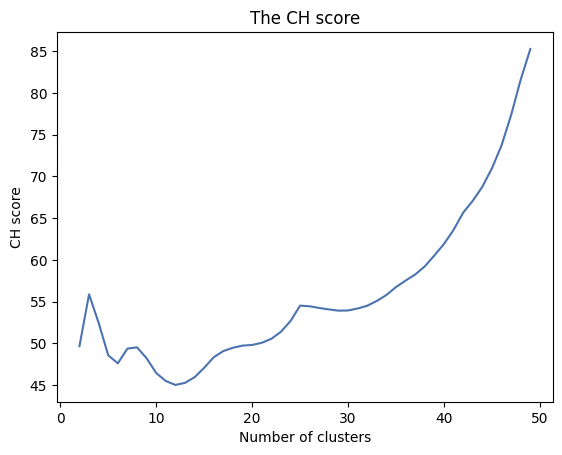

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 8, linkage='ward')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

49.53596821812094

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 5: A, AIG, AMZN, AON, ATVI, AVGO, BRK-B
Cluster 1: AAPL, ABBV, ABT, ADP, AEP, AJG, AMAT, AMD, AMGN, AMT, ANET, AXP, CCI, CDNS, CSX, DG
Cluster 4: ACN, ADI, ADSK, APH, BIIB, BKNG, BLK, C, CAT
Cluster 3: ADBE, ADM, AZO, BAC, BMY, BSX, CSCO, CTAS, DUK
Cluster 7: APD, COST, CRM, DIS
Cluster 6: BA, BDX, ECL, EMR
Cluster 0: CB, CHTR, CL, CMCSA, COF, COP, CTVA, CVS, CVX, D, DE, DHR, DOW
Cluster 2: CI, CME, CMG, DXCM, EL, ELV


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AVGO', 0.15849), ('ABBV', 0.16851), ('APH', 0.0), ('AZO', 0.03343), ('COST', 0.2), ('EMR', 0.19194), ('DE', 0.2), ('CMG', 0.04763)])

Expected annual return: 65.4%
Annual volatility: 17.3%
Sharpe Ratio: 3.66


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.8%
Annual volatility: 3.0%
Sharpe Ratio: 0.58
(0.017596451244646125, 0.030421677641577712, 0.5784181744335105)
Beta: 0.99895979618337
Cumulative return: 1.68%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 7.4%
Annual volatility: 4.9%
Sharpe Ratio: 1.51
(0.07362144632346504, 0.04864756005570244, 1.5133635939637464)
Beta: 1.0263953187956043
Cumulative return: 7.18%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 9.9%
Annual volatility: 6.0%
Sharpe Ratio: 1.65
(0.0989371731904901, 0.06006991295079147, 1.647033736698407)
Beta: 1.0270308980408505
Cumulative return: 9.73%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 5.5%
Annual volatility: 3.9%
Sharpe Ratio: 1.42
(0.055434785296974834, 0.0390122079820831, 1.4209599549565108)
Beta: 1.0914469455193858
Cumulative return: 5.27%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.2%
Annual volatility: 3.6%
Sharpe Ratio: 0.90
(0.032377975208226474, 0.03579970716756979, 0.9044201131778253)
Beta: 1.062772814374686
Cumulative return: 3.09%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Complete Linkage

##### Формируем портфель

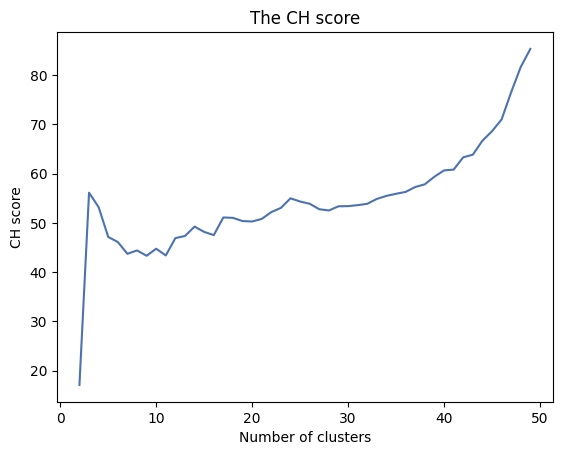

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

44.74305935435587

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 5: A, AMZN, AON, ATVI, AVGO
Cluster 1: AAPL, ABT, ACN, ADI, ADSK, AJG, AMAT, ANET, AXP, BIIB, BLK, CCI, CDNS, CSX, DG
Cluster 9: ABBV, ADP, AEP, AIG, AMD, AMT, BRK-B
Cluster 6: ADBE, ADM, AZO, BAC, BMY, BSX, CSCO, CTAS, DUK
Cluster 3: AMGN, CB, CHTR, CL, CMCSA, COF, CTVA, CVS, CVX
Cluster 0: APD, COST, CRM, DIS
Cluster 7: APH, BKNG, C, CAT
Cluster 4: BA, BDX, ECL, EMR
Cluster 2: CI, CME, CMG, DXCM, EL, ELV
Cluster 8: COP, D, DE, DHR, DOW


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AVGO', 'AJG', 'ABBV', 'AZO', 'CTVA', 'COST', 'APH', 'EMR', 'CMG', 'DE']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AVGO', 0.09987), ('AJG', 0.2), ('ABBV', 0.09605), ('AZO', 0.0), ('CTVA', 0.09783), ('COST', 0.2), ('APH', 0.0), ('EMR', 0.08074), ('CMG', 0.02551), ('DE', 0.2)])

Expected annual return: 69.3%
Annual volatility: 16.7%
Sharpe Ratio: 4.03


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.1%
Annual volatility: 3.0%
Sharpe Ratio: -0.04
(-0.0011513097861722728, 0.03028256433660073, -0.03801890003023137)
Beta: 0.9725351152964858
Cumulative return: -0.11%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.3%
Annual volatility: 4.9%
Sharpe Ratio: 0.67
(0.03298516451286341, 0.048956369079729986, 0.6737665626130077)
Beta: 1.006838207610827
Cumulative return: 3.21%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 6.8%
Annual volatility: 5.8%
Sharpe Ratio: 1.18
(0.06837113572562566, 0.05784133622089215, 1.1820462698946115)
Beta: 0.9847433867536187
Cumulative return: 6.72%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.3%
Annual volatility: 4.0%
Sharpe Ratio: 0.84
(0.03327628433415866, 0.039631315611581876, 0.8396462196787124)
Beta: 1.0740740733415146
Cumulative return: 3.16%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 4.2%
Annual volatility: 3.1%
Sharpe Ratio: 1.35
(0.042148167247905335, 0.03119770017705374, 1.3510023818648589)
Beta: 0.9421221610499029
Cumulative return: 4.03%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Average Linkage

##### Формируем портфель

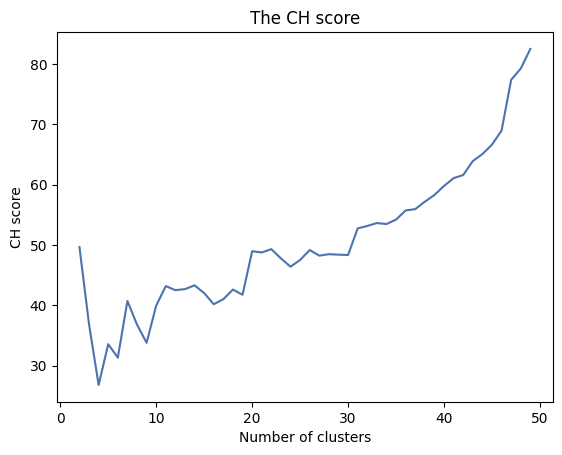

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 11, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

43.20047746361669

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 6: A, ABBV, ADP, AEP, AIG, AMD, AMT, AMZN, AON, AVGO, BRK-B
Cluster 2: AAPL, ABT, AJG, AMAT, AMGN, ANET, AXP, CB, CCI, CDNS, CHTR, CL, CMCSA, COF, CTVA, CVS, CVX, DG
Cluster 1: ACN, ADI, ADSK, APH, BIIB, BKNG, BLK, C, CAT, CSX
Cluster 4: ADBE, ADM, COP, CSCO, CTAS, D, DE, DHR
Cluster 9: APD, COST
Cluster 7: ATVI
Cluster 10: AZO, BAC, BMY, BSX, DUK
Cluster 5: BA, BDX, ECL, EMR
Cluster 0: CI, CME, CMG, DXCM, EL, ELV
Cluster 3: CRM, DIS
Cluster 8: DOW


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'AJG', 'APH', 'DE', 'COST', 'ATVI', 'AZO', 'EMR', 'CMG', 'CRM', 'DOW']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.09309), ('AJG', 0.2), ('APH', 0.0), ('DE', 0.2), ('COST', 0.2), ('ATVI', 0.11832), ('AZO', 0.0), ('EMR', 0.0532), ('CMG', 0.02537), ('CRM', 0.0), ('DOW', 0.11001)])

Expected annual return: 67.5%
Annual volatility: 16.2%
Sharpe Ratio: 4.04


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.4%
Annual volatility: 3.3%
Sharpe Ratio: -0.42
(-0.013817945757113311, 0.03265838285167976, -0.4231056332418062)
Beta: 1.015912573075742
Cumulative return: -1.33%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 0.5%
Annual volatility: 5.1%
Sharpe Ratio: 0.09
(0.004801718679064072, 0.050594657647779186, 0.09490564621450384)
Beta: 1.0547441479401976
Cumulative return: 0.46%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.4%
Annual volatility: 5.9%
Sharpe Ratio: 0.58
(0.03404506283729605, 0.058705900593944864, 0.5799257398805254)
Beta: 0.9930746090556803
Cumulative return: 3.34%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.7%
Annual volatility: 4.0%
Sharpe Ratio: 0.42
(0.01667938677880994, 0.039995182156034766, 0.4170348996971185)
Beta: 1.1255927574131404
Cumulative return: 1.58%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.7%
Annual volatility: 2.9%
Sharpe Ratio: 1.26
(0.0371641147643814, 0.029495868291415595, 1.25997697023883)
Beta: 0.8177766535597623
Cumulative return: 3.55%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Single Linkage

##### Формируем портфель

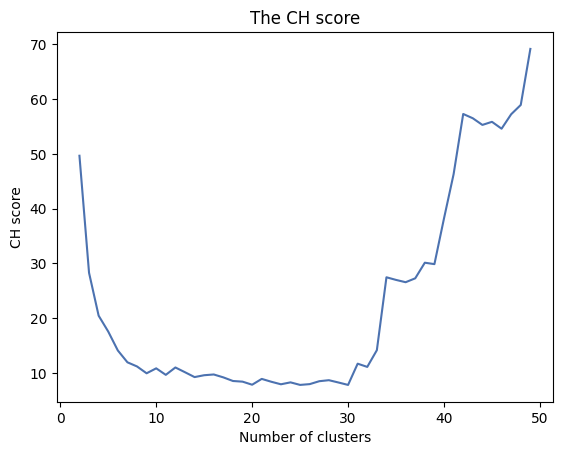

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

10.821611045643676

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 1: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEP, AIG, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APH, AVGO, AXP, AZO, BAC, BIIB, BKNG, BLK, BMY, BRK-B, BSX, C, CB, CCI, CDNS, CHTR, COF, COP, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, D, DE, DG, DHR, DIS, DUK
Cluster 0: APD, COST
Cluster 9: ATVI
Cluster 2: BA, BDX, ECL, EMR
Cluster 8: CAT
Cluster 4: CI, CMG
Cluster 3: CL, CMCSA
Cluster 5: CME
Cluster 7: DOW
Cluster 6: DXCM, EL, ELV


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.0942), ('COST', 0.2), ('ATVI', 0.14186), ('EMR', 0.04508), ('CAT', 0.2), ('CMG', 0.06435), ('CL', 0.07951), ('CME', 0.0), ('DOW', 0.17499), ('DXCM', 0.0)])

Expected annual return: 56.2%
Annual volatility: 16.7%
Sharpe Ratio: 3.26


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01', 
                    '2021-07-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.5%
Annual volatility: 3.5%
Sharpe Ratio: -0.74
(-0.02544698447135035, 0.03455553458030774, -0.7364083577468917)
Beta: 1.0432625130572222
Cumulative return: -2.45%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.3%
Annual volatility: 5.1%
Sharpe Ratio: -0.26
(-0.012952126778207632, 0.05062328977818332, -0.2558531228404974)
Beta: 1.0472710069944593
Cumulative return: -1.29%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-06-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 0.2%
Annual volatility: 6.1%
Sharpe Ratio: 0.03
(0.0020133846515202544, 0.060704490662552985, 0.033166980392148465)
Beta: 1.0284195067711577
Cumulative return: 0.18%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-07-01',
                    '2021-08-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 0.8%
Annual volatility: 3.8%
Sharpe Ratio: 0.20
(0.007836264747144049, 0.038345116543407144, 0.20436147946696942)
Beta: 1.0988516957658023
Cumulative return: 0.73%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2021-08-01',
                    '2021-09-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 2.1%
Annual volatility: 3.4%
Sharpe Ratio: 0.62
(0.02101334695086915, 0.03390403337723353, 0.6197890002367552)
Beta: 0.997068105748897
Cumulative return: 2.01%
Index stats
Expected return: 3.1%
Volatility: 0.0%


## Period 2 (2022 год)

### Без кластеризации

In [ ]:
port = list(df_stocks.columns)

In [ ]:
weights = optimize_portfolio(stocks_df, port, (0, 1))

OrderedDict([('A', 0.0), ('AAPL', 0.0), ('ABBV', 0.0), ('ABT', 0.0), ('ACN', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEP', 0.0), ('AIG', 0.0), ('AJG', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANET', 0.02171), ('AON', 0.0), ('APD', 0.0), ('APH', 0.0), ('ATVI', 0.0), ('AVGO', 0.0), ('AXP', 0.0), ('AZO', 0.05487), ('BA', 0.0), ('BAC', 0.0), ('BDX', 0.0), ('BIIB', 0.0), ('BKNG', 0.0), ('BLK', 0.0), ('BMY', 0.0), ('BRK-B', 0.0), ('BSX', 0.0), ('C', 0.0), ('CAT', 0.0), ('CB', 0.0), ('CCI', 0.0), ('CDNS', 0.0), ('CHTR', 0.0), ('CI', 0.0), ('CL', 0.0), ('CMCSA', 0.0), ('CME', 0.0), ('CMG', 0.0), ('COF', 0.0), ('COP', 0.04508), ('COST', 0.0), ('CRM', 0.0), ('CSCO', 0.0), ('CSX', 0.0), ('CTAS', 0.0), ('CTVA', 0.0), ('CVS', 0.0), ('CVX', 0.0), ('D', 0.0), ('DE', 0.0), ('DG', 0.0), ('DHR', 0.0), ('DIS', 0.0), ('DOW', 0.0), ('DUK', 0.0), ('DXCM', 0.0), ('ECL', 0.0), ('EL', 0.0), ('ELV', 0.0), ('EMR', 0.0), ('EOG', 0.0),

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    port, 
                    weights)

Portfolio stats
Expected annual return: -4.8%
Annual volatility: 5.6%
Sharpe Ratio: -0.86
(-0.04765886711663095, 0.05567980126645598, -0.8559453524009396)
Beta: 0.9415048733223075
Cumulative return: -4.56%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    port, 
                    weights)

/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


Portfolio stats
Expected annual return: -7.1%
Annual volatility: 8.6%
Sharpe Ratio: -0.83
(-0.07115368812511685, 0.08564243436927897, -0.8308228117186798)
Beta: 0.900984557472361
Cumulative return: -6.98%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    port, 
                    weights)

/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


Portfolio stats
Expected annual return: 0.9%
Annual volatility: 10.9%
Sharpe Ratio: 0.09
(0.009410103811471303, 0.10874261332583515, 0.08653556801393923)
Beta: 0.8930442090519309
Cumulative return: 0.9%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    port, 
                    weights)

Portfolio stats
Expected annual return: -2.9%
Annual volatility: 6.8%
Sharpe Ratio: -0.42
(-0.02883638862606633, 0.06797157387941567, -0.4242418849565445)
Beta: 0.914564246754434
Cumulative return: -2.78%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    port, 
                    weights)

Portfolio stats
Expected annual return: 8.9%
Annual volatility: 6.6%
Sharpe Ratio: 1.35
(0.08914428588846113, 0.06622491506029939, 1.3460838085982156)
Beta: 0.8995586086783879
Cumulative return: 8.52%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Корреляция

In [ ]:
stocks_df = get_df_between_dates(df_stocks, '2021-01-01', '2022-01-01')

In [ ]:
stocks_df.shape

(252, 200)

In [ ]:
index_2022 = get_df_between_dates(index_df, '2021-01-01', '2022-01-01')

In [ ]:
returns = get_sharpe_ratio_info(stocks_df)

In [ ]:
returns

,ticker,mean_return,var,sharpe_ratio
0,A,0.165305,0.098413,1.476484
1,AAPL,0.283323,0.130615,2.016026
2,ABBV,0.250540,0.068056,3.387517
3,ABT,0.065108,0.086288,0.522765
4,ACN,0.115150,0.105925,0.898273
...,...,...,...,...
195,WM,0.135625,0.062654,1.845470
196,WMT,0.085804,0.063108,1.042735
197,XEL,0.052911,0.078064,0.421585
198,XOM,0.210444,0.157595,1.208439


In [ ]:
dissimilarity = get_corr_dissimilarity_matrix(stocks_df)

In [ ]:
dissimilarity

array([[0.        , 0.74117636, 0.95299967, ..., 1.17602319, 1.02681717,
        0.55196351],
       [0.        , 0.        , 0.67050298, ..., 1.27809317, 1.10931763,
        0.38556004],
       [0.        , 0.        , 0.        , ..., 1.02707533, 0.9387539 ,
        0.59806361],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.24545348,
        1.19429971],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.89775403],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Ward Linkage

##### Формируем портфель

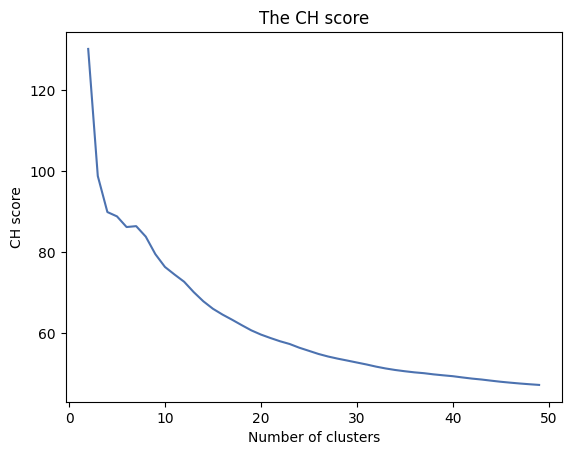

In [ ]:
calinski_harabasz_method(dissimilarity, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 8, linkage='ward')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

83.75554161445248

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 4: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEP, AIG, AJG, AMAT, AMD, AMT, AMZN, ANET, AON, APD, APH, AVGO, AZO
Cluster 3: AMGN, ATVI, BA, BDX, BIIB, BKNG, BMY, C, CAT, CI, CL, CMCSA
Cluster 1: AXP, BAC, BLK, BRK-B, BSX, CB, CCI, CDNS, CHTR, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CVS, CVX, DG, DHR, DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F
Cluster 6: CTVA, D, DE, DIS, DOW, FCX, FDX, FISV, GE, GM, HES, HON, HUM, IBM, INTC
Cluster 5: FTNT, GD, GILD, GIS, GOOG, GOOGL, GS, HCA, HD, HLT, HSY, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LOW
Cluster 7: LMT, LRCX, MA, MAR, MCHP, MDT, MMM, MNST, MO, MU, NEM
Cluster 2: MCD, MCK, MCO, MDLZ, MET, META, MMC, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, NEE, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM
Cluster 0: REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'CAT', 'COST', 'DE', 'GIS', 'MNST', 'MCK', 'SNPS']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
2,ABBV,0.250540,0.068056,3.387517
36,CAT,0.165746,0.122832,1.186546
48,COST,0.197245,0.071714,2.471547
57,DE,0.316416,0.136831,2.166295
81,GIS,0.202338,0.059678,3.055378
116,MCK,0.348736,0.099169,3.314911
124,MNST,0.176919,0.083383,1.881905
168,SNPS,0.359021,0.146394,2.315807


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.2), ('CAT', 0.0), ('COST', 0.2), ('DE', 0.11023), ('GIS', 0.17205), ('MNST', 0.0), ('MCK', 0.2), ('SNPS', 0.11771)])

Expected annual return: 37.6%
Annual volatility: 13.0%
Sharpe Ratio: 2.73


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.3%
Annual volatility: 3.6%
Sharpe Ratio: -0.36
(-0.012989248972094707, 0.035941617303444, -0.3613985665261104)
Beta: 0.5905757405135976
Cumulative return: -1.25%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.0%
Annual volatility: 5.9%
Sharpe Ratio: 0.18
(0.010456468735742037, 0.05899775340142253, 0.17723503240192728)
Beta: 0.597508324985777
Cumulative return: 1.01%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 11.4%
Annual volatility: 7.5%
Sharpe Ratio: 1.52
(0.11430484084147659, 0.07529726735986175, 1.5180476642690006)
Beta: 0.5722413070565107
Cumulative return: 11.23%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 2.4%
Annual volatility: 4.8%
Sharpe Ratio: 0.50
(0.024036151498871106, 0.04831965090309538, 0.4974405040109952)
Beta: 0.6312437722542956
Cumulative return: 2.28%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 10.5%
Annual volatility: 4.6%
Sharpe Ratio: 2.27
(0.1048423141915551, 0.04617572993500164, 2.270506916493455)
Beta: 0.5402068962371303
Cumulative return: 10.02%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Формируем портфель

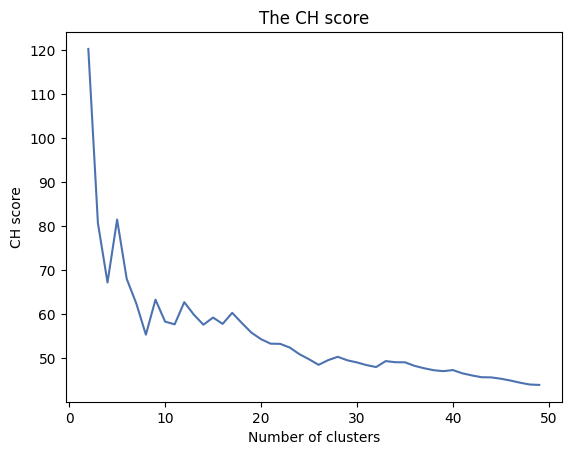

In [ ]:
calinski_harabasz_method(dissimilarity, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 5, linkage='complete')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

81.46810001921072

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, AEP, AIG, AJG, AMAT, AMD, AMT, ANET, AON, APH, AVGO, AXP, AZO, BAC, BLK, BRK-B, BSX, CB, CCI, CDNS, CHTR, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CVS, CVX, DG, DHR
Cluster 0: ADSK, AMGN, AMZN, APD, ATVI, BA, BDX, BIIB, BKNG, BMY, C, CAT, CI, CL, CMCSA, DIS, DOW
Cluster 1: CTVA, D, DE, FCX, FDX, FISV, GE, GM, HES, HON, HUM, IBM, INTC
Cluster 2: DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F, FTNT, GD, GILD, GIS, GOOG, GOOGL, GS, HCA, HD, HLT, HSY, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LMT, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PXD
Cluster 4: PSX, PYPL, QCOM, REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, TMUS, TRV, TSLA, TT, TX

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'CAT', 'DE', 'MCK', 'SNPS']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
2,ABBV,0.250540,0.068056,3.387517
36,CAT,0.165746,0.122832,1.186546
57,DE,0.316416,0.136831,2.166295
116,MCK,0.348736,0.099169,3.314911
168,SNPS,0.359021,0.146394,2.315807


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.2), ('CAT', 0.2), ('DE', 0.2), ('MCK', 0.2), ('SNPS', 0.2)])

Expected annual return: 33.9%
Annual volatility: 16.7%
Sharpe Ratio: 1.91


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.0%
Annual volatility: 3.9%
Sharpe Ratio: -0.01
(-0.00040137463533966924, 0.039381003368905515, -0.010192087580393824)
Beta: 0.4854877892949414
Cumulative return: -0.05%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.7%
Annual volatility: 7.2%
Sharpe Ratio: -0.10
(-0.007405233341613051, 0.07157384277712192, -0.10346284416602657)
Beta: 0.7037238769013578
Cumulative return: -0.74%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 13.1%
Annual volatility: 8.9%
Sharpe Ratio: 1.46
(0.13056224182970497, 0.08929557460260722, 1.4621356367406462)
Beta: 0.6545255821466598
Cumulative return: 12.83%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.7%
Annual volatility: 6.2%
Sharpe Ratio: -0.12
(-0.0074793035413172546, 0.06202701805498127, -0.12058138172445332)
Beta: 0.8923157876464928
Cumulative return: -0.72%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 14.4%
Annual volatility: 5.1%
Sharpe Ratio: 2.84
(0.1438145125464115, 0.05060261024159165, 2.8420374336382848)
Beta: 0.5634790949212034
Cumulative return: 13.74%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Формируем портфель

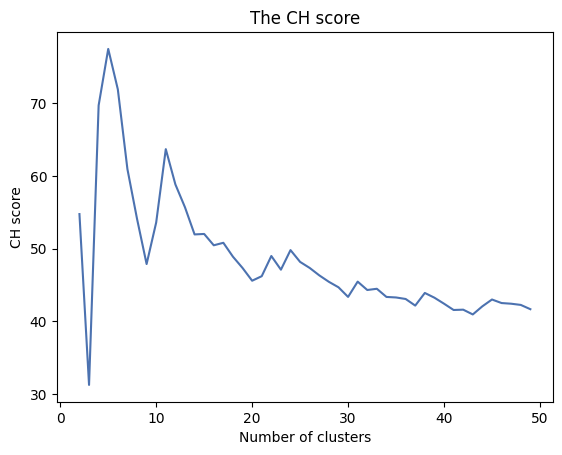

In [ ]:
calinski_harabasz_method(dissimilarity, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 5, linkage='average')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

77.4618164257009

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 4: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, AEP, AIG, AJG, AMAT, AMD, AMT, AMZN, ANET, AON, APD, APH, AVGO, AZO
Cluster 2: ADSK, AMGN, ATVI, BA, BDX, BIIB, BKNG, BMY, C, CAT, CI, CL, CMCSA
Cluster 0: AXP, BAC, BLK, BRK-B, BSX, CB, CCI, CDNS, CHTR, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, D, DE, DG, DHR, DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F, FCX, FTNT, GD, GE, GILD, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LMT, LOW, LRCX, MA, MAR, MCHP, MDT, MMM, MNST, MO, MU, NEM
Cluster 1: DIS, DOW, FDX, FISV, INTC
Cluster 3: MCD, MCK, MCO, MDLZ, MET, META, MMC, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, NEE, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, TMUS, TRV, TSLA, TT, TX

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'CAT', 'GIS', 'FDX', 'MCK']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
2,ABBV,0.250540,0.068056,3.387517
36,CAT,0.165746,0.122832,1.186546
75,FDX,0.145165,0.171703,0.728959
81,GIS,0.202338,0.059678,3.055378
116,MCK,0.348736,0.099169,3.314911


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.2), ('CAT', 0.2), ('GIS', 0.2), ('FDX', 0.2), ('MCK', 0.2)])

Expected annual return: 23.2%
Annual volatility: 14.0%
Sharpe Ratio: 1.52


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.1%
Annual volatility: 3.3%
Sharpe Ratio: 0.33
(0.010841990220272102, 0.03291135896339088, 0.3294300375846602)
Beta: 0.17098736031296144
Cumulative return: 1.03%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.6%
Annual volatility: 5.5%
Sharpe Ratio: -0.30
(-0.016498519981880948, 0.05527005083206879, -0.2985074146577078)
Beta: 0.3375253266711912
Cumulative return: -1.62%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 8.4%
Annual volatility: 7.4%
Sharpe Ratio: 1.13
(0.08354164369589837, 0.0741156552702023, 1.1271794520514173)
Beta: 0.4241617819420098
Cumulative return: 8.2%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.9%
Annual volatility: 4.6%
Sharpe Ratio: -0.64
(-0.029274766409914582, 0.04563718513002436, -0.6414673982741966)
Beta: 0.4712839623807829
Cumulative return: -2.8%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 10.4%
Annual volatility: 4.8%
Sharpe Ratio: 2.17
(0.10394823766713353, 0.047817038292407986, 2.173874446833685)
Beta: 0.5253760932660219
Cumulative return: 9.93%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Формируем портфель

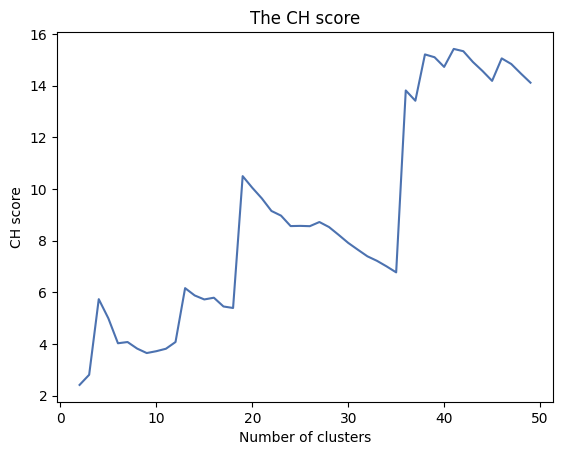

In [ ]:
calinski_harabasz_method(dissimilarity, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 19, linkage='single')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

10.498953847534935

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, AIG, AJG, AMAT, AMD, AMT, ANET, AON, APH, AVGO, AXP, AZO, BAC, BLK, BRK-B, BSX, CB, CCI, CDNS, CHTR, COF
Cluster 11: ADSK
Cluster 13: AEP
Cluster 9: AMGN
Cluster 2: AMZN, APD
Cluster 14: ATVI
Cluster 10: BA
Cluster 4: BDX
Cluster 7: BIIB, BMY
Cluster 15: BKNG
Cluster 3: C, CAT, CI, CL, CMCSA
Cluster 1: CME, CMG, COP, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, D, DE, DG, DHR, DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F, FCX, FTNT, GD, GILD, GIS, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LOW, LRCX, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, NEE, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, T

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV',
 'ADSK',
 'AEP',
 'AMGN',
 'APD',
 'ATVI',
 'BA',
 'BDX',
 'BMY',
 'BKNG',
 'CAT',
 'MCK',
 'DIS',
 'DOW',
 'FDX',
 'GE',
 'INTC',
 'LMT',
 'NEM']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
2,ABBV,0.250540,0.068056,3.387517
9,ADSK,0.032207,0.197900,0.061681
10,AEP,0.026128,0.074929,0.081777
15,AMGN,0.032745,0.075209,0.169455
20,APD,0.094157,0.102910,0.720601
22,ATVI,0.129671,0.109578,1.000848
26,BA,-0.128136,0.349744,-0.423556
28,BDX,-0.008258,0.071592,-0.394710
30,BKNG,0.078734,0.178394,0.329237
32,BMY,0.058090,0.052093,0.731188


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.2), ('ADSK', 0.0), ('AEP', 0.2), ('AMGN', 0.0), ('APD', 0.2), ('ATVI', 0.0), ('BA', 0.0), ('BDX', 0.01871), ('BMY', 0.0), ('BKNG', 0.0), ('CAT', 0.10318), ('MCK', 0.2), ('DIS', 0.0), ('DOW', 0.0), ('FDX', 0.0), ('GE', 0.00196), ('INTC', 0.0), ('LMT', 0.07615), ('NEM', 0.0)])

Expected annual return: 23.7%
Annual volatility: 12.6%
Sharpe Ratio: 1.73


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.1%
Annual volatility: 2.6%
Sharpe Ratio: 0.41
(0.010663711434822878, 0.026066781461377826, 0.4090919874639261)
Beta: 0.1868243674292913
Cumulative return: 1.01%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.4%
Annual volatility: 5.3%
Sharpe Ratio: 0.27
(0.014016181754307647, 0.05253559737638863, 0.26679399215525085)
Beta: 0.34787387429912137
Cumulative return: 1.34%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 12.2%
Annual volatility: 6.5%
Sharpe Ratio: 1.86
(0.1218184025281715, 0.06535177478545104, 1.8640412280783438)
Beta: 0.3475077043881962
Cumulative return: 11.96%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 0.0%
Annual volatility: 4.7%
Sharpe Ratio: 0.00
(8.13682433260729e-05, 0.047153893582635976, 0.001725589068980638)
Beta: 0.4787827450699042
Cumulative return: -0.03%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 11.3%
Annual volatility: 3.7%
Sharpe Ratio: 3.06
(0.11267470176543126, 0.036791420551015176, 3.0625265368374652)
Beta: 0.3161255865028754
Cumulative return: 10.77%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Мультипликаторы

#### Ward Linkage

##### Формируем портфель

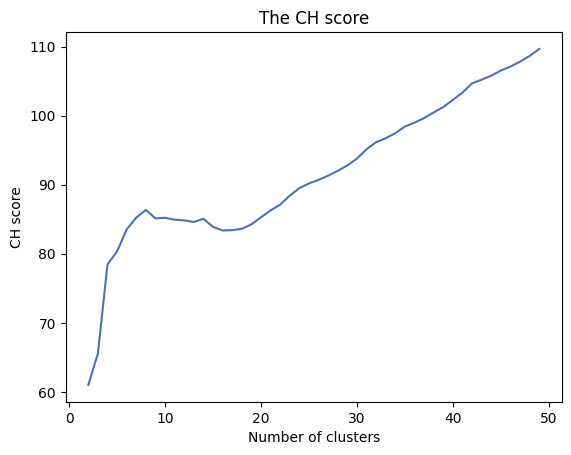

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 17, linkage='ward')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

83.41569823046144

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AEP, AMZN, APH, CTVA, DHR, IBM, JPM, LHX, MNST, MSI, PG, PXD, ROP
Cluster 4: AAPL, BRK-B, CHTR, CMG, CSX, DOW, GD, HON, INTU, MS, MSCI, OXY
Cluster 1: ABBV, ADM, ADP, ATVI, AVGO, BA, CAT, CVS, DUK, EQIX, ETN, GILD, IDXX, META, MMM, MRNA, NKE, ORLY, PEP
Cluster 10: ABT, COF, LLY, PH, RTX
Cluster 2: ACN, ADI, ADSK, AIG, AMD, APD, AXP, BKNG, CB, CRM, ECL, EL, EW, FCX, FTNT, GM, INTC, ITW, JCI, KLAC, MAR, MDLZ, NXPI, O, PNC
Cluster 9: ADBE, AZO, CDNS, DE, EMR, EXC, GOOG, GOOGL, HCA, MDT, MMC, NEM, NFLX
Cluster 16: AJG, CTAS, MET
Cluster 6: AMAT, AMGN, ANET, ELV, GIS, HUM, KMB, MSFT, NVDA
Cluster 14: AMT, BDX, CMCSA, CSCO, DG, F, LOW, MA, MCK, PM
Cluster 13: AON, BAC, CCI, CI, COST, GE, ICE, ISRG, KO, LIN, LMT, LRCX, MCHP, MRK, NEE, NOW, NUE, PFE, PLD, PSX, PYPL
Cluster 7: BIIB, BLK, BMY, BSX, CME, FDX, GS, HES, ORCL, REGN
Cluster 15: C
Cluster 5: CL, COP, D, EOG, HD, MO, MPC, MU, NOC, PSA
Cluster 11: CVX, QCOM
Cluster 3: DIS, DXCM, HLT, JNJ, PGR
Cluster 8: FISV, MCD, MCO
Clus

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['CTVA',
 'AAPL',
 'ABBV',
 'LLY',
 'FTNT',
 'CDNS',
 'AJG',
 'GIS',
 'MCK',
 'COST',
 'REGN',
 'C',
 'PSA',
 'CVX',
 'PGR',
 'MCD',
 'HSY']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('CTVA', 0.0), ('AAPL', 0.0), ('ABBV', 0.0), ('LLY', 0.11596), ('FTNT', 0.2), ('CDNS', 0.0), ('AJG', 0.00903), ('GIS', 0.0), ('MCK', 0.00508), ('COST', 0.07415), ('REGN', 0.0), ('C', 0.0), ('PSA', 0.2), ('CVX', 0.1489), ('PGR', 0.0), ('MCD', 0.14023), ('HSY', 0.10666)])

Expected annual return: 71.5%
Annual volatility: 13.2%
Sharpe Ratio: 5.25


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.7%
Annual volatility: 4.5%
Sharpe Ratio: -0.60
(-0.027379874970517155, 0.04547315878995925, -0.60211068901074)
Beta: 0.7882652938542944
Cumulative return: -2.62%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.8%
Annual volatility: 7.2%
Sharpe Ratio: 0.25
(0.01775422619900059, 0.07224941315522145, 0.2457352305527688)
Beta: 0.7902895140931593
Cumulative return: 1.71%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 10.0%
Annual volatility: 9.1%
Sharpe Ratio: 1.09
(0.09970892867768573, 0.09116818031457624, 1.0936812420039492)
Beta: 0.7440198984133053
Cumulative return: 9.79%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 4.6%
Annual volatility: 5.7%
Sharpe Ratio: 0.80
(0.04556954238491172, 0.057310763256558414, 0.7951306141381205)
Beta: 0.8302685908754475
Cumulative return: 4.31%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 8.3%
Annual volatility: 5.7%
Sharpe Ratio: 1.46
(0.08318352423125479, 0.056785685804891795, 1.4648678280836922)
Beta: 0.720322778616155
Cumulative return: 7.95%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Формируем портфель

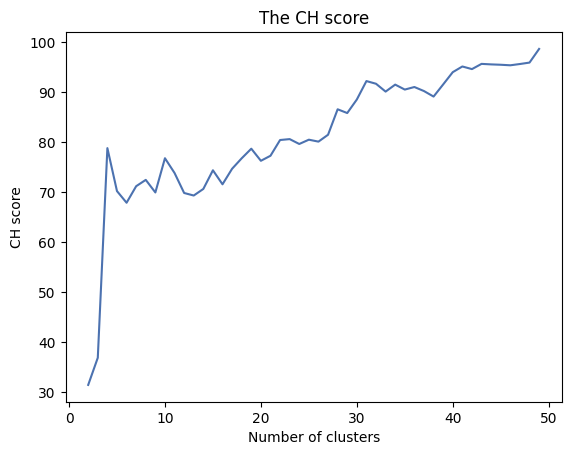

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

76.74316926545882

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, AAPL, ACN, ADI, ADSK, AIG, AMD, APD, AXP, BKNG, CB, CHTR, CME, CMG, CSX, DOW, ECL, FTNT, GD, GM, HD, HES, HON, IBM, INTC, INTU, ITW, JCI, KLAC, MAR, MDLZ, MS, MSCI, MU, O, OXY, PSA, REGN
Cluster 2: ABBV, ADM, ADP, AMT, AON, BA, BAC, BDX, CAT, CCI, CI, CMCSA, COST, CSCO, DG, DUK, EQIX, ETN, F, GE, GILD, ICE, ISRG, KO, LIN, LMT, LOW, LRCX, MA, MCHP, MCK, META, MMM, MRK, MRNA, NEE, NKE, NOW, NUE, ORLY, PEP, PFE, PLD, PM, PSX, PYPL
Cluster 9: ABT, AEP, AMZN, APH, BIIB, BLK, BMY, BSX, CTVA, DHR, FDX, GS, JPM, LHX, LLY, MNST, MSI, ORCL, PG, PXD, ROP
Cluster 4: ADBE, AJG, ATVI, AVGO, AZO, CDNS, CTAS, CVS, DE, EMR, EXC, GOOG, GOOGL, HCA, IDXX, MDT, MET, MMC, NEM, NFLX
Cluster 6: AMAT, AMGN, ANET, BRK-B, ELV, GIS, HUM, KMB, MSFT, NVDA
Cluster 7: C
Cluster 5: CL, COP, CRM, D, DIS, DXCM, EL, EOG, EW, FCX, HLT, JNJ, MO, MPC, NOC, NXPI, PNC
Cluster 8: COF, PH, RTX
Cluster 1: CVX, PGR, QCOM
Cluster 0: FISV, HSY, MCD, MCO, NSC


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['REGN', 'ABBV', 'LLY', 'AJG', 'GIS', 'C', 'FCX', 'PH', 'PGR', 'HSY']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('REGN', 0.06003), ('ABBV', 0.17686), ('LLY', 0.2), ('AJG', 0.2), ('GIS', 0.08731), ('C', 0.0), ('FCX', 0.0758), ('PH', 0.0), ('PGR', 0.0), ('HSY', 0.2)])

Expected annual return: 42.6%
Annual volatility: 13.2%
Sharpe Ratio: 3.07


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.7%
Annual volatility: 3.2%
Sharpe Ratio: -0.86
(-0.02742202092749182, 0.031860387661094204, -0.8606932602071813)
Beta: 0.5014343262793279
Cumulative return: -2.62%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.3%
Annual volatility: 5.4%
Sharpe Ratio: 0.24
(0.013326424323990192, 0.054491011264930646, 0.2445618830452284)
Beta: 0.50971695463229
Cumulative return: 1.29%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 12.3%
Annual volatility: 7.5%
Sharpe Ratio: 1.63
(0.12284006806899217, 0.07525033904125412, 1.6324187988262506)
Beta: 0.5089486645456756
Cumulative return: 12.07%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 4.2%
Annual volatility: 4.5%
Sharpe Ratio: 0.94
(0.04198989074378745, 0.04463320505976343, 0.9407769549052861)
Beta: 0.5408830153852666
Cumulative return: 3.98%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 11.4%
Annual volatility: 5.1%
Sharpe Ratio: 2.23
(0.11407750884875939, 0.05121347167169516, 2.227490250613261)
Beta: 0.5004643117507068
Cumulative return: 10.9%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Формируем портфель

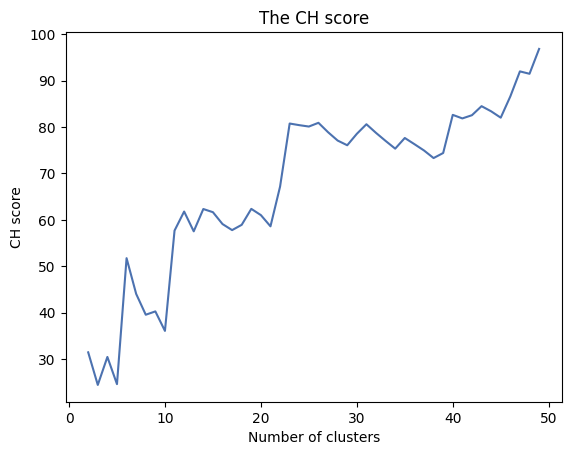

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 23, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

80.76493716819245

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, IBM, ROP
Cluster 8: AAPL, CB, CHTR, CMG, CSX, DOW, GD, GM, HON, INTU, MAR, MS, MSCI, OXY
Cluster 6: ABBV, ADP, AON, BA, BAC, CAT, CI, DG, DUK, EQIX, ETN, F, GE, GILD, LRCX, MCHP, MCK, META, MMM, NKE, NOW, PEP, PM, PYPL
Cluster 0: ABT, AEP, APH, CMCSA, LHX, LLY, LOW, PH
Cluster 11: ACN, ADI, ADSK, AIG, AMD, APD, AXP, BKNG, CCI, COST, CRM, CTVA, ECL, EL, EW, FCX, FTNT, ICE, INTC, ISRG, ITW, JCI, KLAC, KO, LIN, LMT, MDLZ, MRK, MSI, NEE, NUE, NXPI, O, PFE, PLD, PNC, PSX
Cluster 22: ADBE, ATVI, AVGO, AZO, CDNS, CVS, DE, EMR, EXC, GOOG, GOOGL, HCA, IDXX, MDT, MMC, NEM, NFLX
Cluster 1: ADM, DIS, DXCM, HLT, JNJ, MRNA, ORLY
Cluster 14: AJG, CTAS, MET
Cluster 5: AMAT, AMGN, ANET, GIS, MSFT, NVDA
Cluster 18: AMT, BDX, CSCO, MA
Cluster 21: AMZN, BIIB, BLK, BMY, BSX, CME, DHR, FDX, GS, MNST, ORCL, PG, REGN
Cluster 12: BRK-B
Cluster 15: C
Cluster 2: CL, D, EOG, HD, HES, MO, MPC, MU, NOC, PSA
Cluster 19: COF
Cluster 20: COP
Cluster 10: CVX, QCOM
Cluster 9: ELV, HUM, KMB
Cluster 4: FISV,

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['A',
 'AAPL',
 'ABBV',
 'LLY',
 'COST',
 'CDNS',
 'ORLY',
 'AJG',
 'GIS',
 'CSCO',
 'REGN',
 'BRK-B',
 'C',
 'PSA',
 'COF',
 'COP',
 'CVX',
 'ELV',
 'MCD',
 'HSY',
 'PXD',
 'PGR',
 'RTX']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('A', 0.03527), ('AAPL', 0.0), ('ABBV', 0.0), ('LLY', 0.12722), ('COST', 0.19813), ('CDNS', 0.0), ('ORLY', 0.13561), ('AJG', 0.00811), ('GIS', 0.0), ('CSCO', 0.02977), ('REGN', 0.0), ('BRK-B', 0.0), ('C', 0.0), ('PSA', 0.2), ('COF', 0.0), ('COP', 0.15402), ('CVX', 0.0), ('ELV', 0.04664), ('MCD', 0.06523), ('HSY', 0.0), ('PXD', 0.0), ('PGR', 0.0), ('RTX', 0.0)])

Expected annual return: 62.5%
Annual volatility: 12.3%
Sharpe Ratio: 4.92


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01',
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.0%
Annual volatility: 4.5%
Sharpe Ratio: -0.45
(-0.02034780270750485, 0.045344438462518386, -0.44873866338259544)
Beta: 0.7454378850960026
Cumulative return: -1.97%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.4%
Annual volatility: 6.7%
Sharpe Ratio: -0.07
(-0.004482236516722669, 0.06683541272338292, -0.06706379648276671)
Beta: 0.6438196972751982
Cumulative return: -0.46%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 7.7%
Annual volatility: 8.0%
Sharpe Ratio: 0.97
(0.07689618983141892, 0.07960483883090835, 0.9659738146666816)
Beta: 0.5659563982524421
Cumulative return: 7.55%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 1.4%
Annual volatility: 5.1%
Sharpe Ratio: 0.27
(0.013825708344755742, 0.05106022951358675, 0.27077254600034306)
Beta: 0.6022586707962799
Cumulative return: 1.31%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 8.6%
Annual volatility: 4.3%
Sharpe Ratio: 2.01
(0.08627311943356636, 0.042949437915556284, 2.0087135855698413)
Beta: 0.45945457642967913
Cumulative return: 8.25%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Формируем портфель

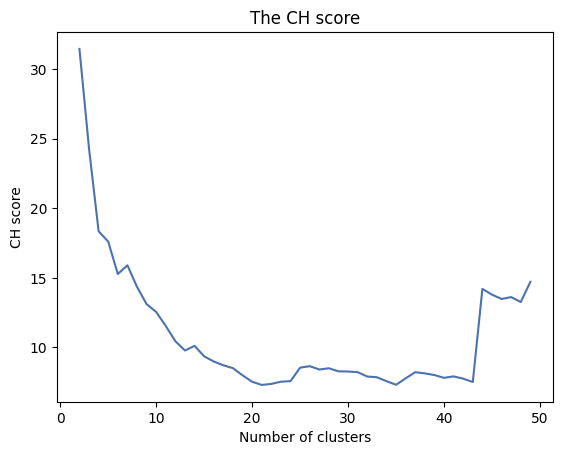

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 7, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

15.902581926396943

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEP, AIG, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APD, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BDX, BIIB, BKNG, BLK, BMY, BRK-B, BSX, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CME, CMG, COP, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, D, DE, DG, DHR, DIS, DOW, DUK, DXCM, ECL, EL, ELV, EMR, EOG, EQIX, ETN, EW, EXC, F, FCX, FDX, FTNT, GD, GE, GILD, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HUM, IBM, ICE, IDXX, INTC, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LMT, LOW, LRCX, MA, MAR, MCHP, MCK, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, REGN, ROP, RTX
Cluster 3: C
Cluster 5: COF
Cluster 1: CVX, QCOM
Cluster 2: FISV, MCD, MCO
Cluster 6: HSY, NSC
Cluster 4: PGR


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['ABBV', 'C', 'COF', 'CVX', 'MCD', 'HSY', 'PGR']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('ABBV', 0.2), ('C', 0.0), ('COF', 0.18922), ('CVX', 0.2), ('MCD', 0.2), ('HSY', 0.2), ('PGR', 0.01078)])

Expected annual return: 38.3%
Annual volatility: 13.9%
Sharpe Ratio: 2.60


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.1%
Annual volatility: 2.7%
Sharpe Ratio: 1.15
(0.030907533570877093, 0.02698772418123288, 1.145244162246553)
Beta: 0.2904612208280391
Cumulative return: 2.93%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 5.9%
Annual volatility: 5.1%
Sharpe Ratio: 1.17
(0.05932468307708613, 0.05084055484008361, 1.1668771763740369)
Beta: 0.31392670624050717
Cumulative return: 5.76%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 11.7%
Annual volatility: 6.2%
Sharpe Ratio: 1.88
(0.11714355000430271, 0.062178384951425726, 1.8839915204586968)
Beta: 0.34197404442322693
Cumulative return: 11.49%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 2.6%
Annual volatility: 4.5%
Sharpe Ratio: 0.58
(0.02574542668008964, 0.04467227796015778, 0.576317749075868)
Beta: 0.34528723126649274
Cumulative return: 2.43%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 5.2%
Annual volatility: 3.7%
Sharpe Ratio: 1.38
(0.051642469120063775, 0.03734562769273734, 1.3828250403221034)
Beta: 0.41457147075366474
Cumulative return: 4.94%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Просадки

In [ ]:
# https://drive.google.com/file/d/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce/view?usp=sharing

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce' -O drawdowns-2021.csv

--2023-05-07 12:55:39--  https://docs.google.com/uc?export=download&id=1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce
Resolving docs.google.com (docs.google.com)... 74.125.137.100, 74.125.137.101, 74.125.137.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pq2hgabi9jporcav9n21b0n691qv3iai/1683464100000/11915959673283641640/*/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce?e=download&uuid=38d5d542-040d-4221-8be4-b54004d36f41 [following]
--2023-05-07 12:55:40--  https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pq2hgabi9jporcav9n21b0n691qv3iai/1683464100000/11915959673283641640/*/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce?e=download&uuid=38d5d542-040d-4221-8be4-b54004d36f41
Resolving doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0

In [ ]:
drawdowns_2021 = pd.read_csv('drawdowns-2021.csv', 
                             sep=';', 
                             decimal=',', 
                             index_col=0, 
                             header=0, 
                             names=['Ticker', 
                                    'return', 
                                    'risk', 
                                    'cum_drawdown', 
                                    'max_drawdown'])
drawdowns_2020

,Ticker,return,risk,cum_drawdown,max_drawdown
1,AAPL,0.591955,0.029405,14.764558,58.965542
2,MSFT,0.343873,0.027716,14.901497,41.541118
3,ATVI,0.446354,0.024419,17.671408,43.941842
4,EA,0.289448,0.022881,24.337867,40.837019
5,HPQ,0.179479,0.034794,36.158227,46.685645
...,...,...,...,...,...
64,COP,-0.486219,0.046097,66.543214,65.899519
65,CVX,-0.355573,0.038922,69.627463,55.348761
66,EOG,-0.518536,0.048654,65.799384,66.670400
67,SLB,-0.610582,0.049686,55.099437,70.480157


In [ ]:
drawdowns_2020.isna().sum().sum()

0

In [ ]:
drawdowns_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 1 to 68
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        68 non-null     object 
 1   return        68 non-null     float64
 2   risk          68 non-null     float64
 3   cum_drawdown  68 non-null     float64
 4   max_drawdown  68 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.2+ KB


In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(drawdowns_2021.drop('Ticker', axis=1)) 

In [ ]:
data.shape

(68, 4)

#### Ward Linkage

##### Формируем портфель

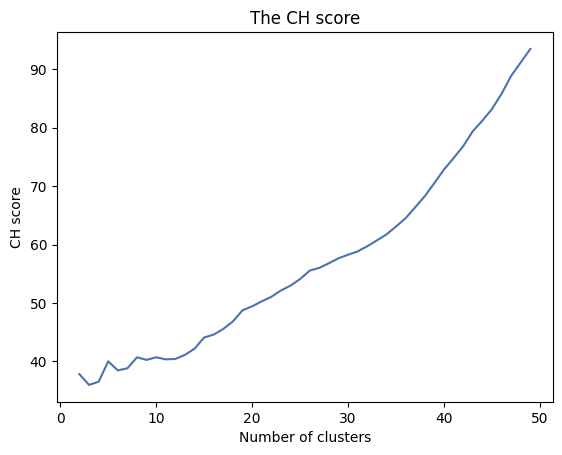

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='ward')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

40.717828185133214

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 8: A, AEP, AIG, AMT, BMY, BRK-B, BSX, CCI, CSX
Cluster 1: AAPL, ACN, AJG, ANET, AON, AZO, BDX, BIIB, BKNG, BLK, CDNS, CHTR, CL, CVX, DE, DG, EMR
Cluster 9: ABBV, CSCO
Cluster 0: ABT, ADBE, ADSK, AMAT, AMD, AMGN, AMZN, APD, APH, AVGO, BA
Cluster 2: ADI, ADM, ATVI, CAT, CI, DXCM, EL
Cluster 4: ADP, AXP, BAC, CB, CMCSA, COF, CRM, CTVA, CVS, D, DHR, ECL
Cluster 3: C, COST, DUK, ELV
Cluster 5: CME
Cluster 7: CMG
Cluster 6: COP, CTAS, DIS, DOW


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['A', 'AJG', 'ABBV', 'AVGO', 'ADM', 'CTVA', 'COST', 'CME', 'CMG', 'CTAS']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('A', 0.2), ('AJG', 0.2), ('ABBV', 0.0), ('AVGO', 0.08908), ('ADM', 0.2), ('CTVA', 0.14188), ('COST', 0.16904), ('CME', 0.0), ('CMG', 0.0), ('CTAS', 0.0)])

Expected annual return: 59.2%
Annual volatility: 16.5%
Sharpe Ratio: 3.46


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -3.4%
Annual volatility: 6.0%
Sharpe Ratio: -0.57
(-0.034251668472917086, 0.05989266890609773, -0.5718841570847061)
Beta: 1.0163820519812017
Cumulative return: -3.28%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -2.8%
Annual volatility: 8.4%
Sharpe Ratio: -0.33
(-0.028080218840044132, 0.08430876959021379, -0.3330640332735157)
Beta: 0.9559489155912093
Cumulative return: -2.76%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 8.9%
Annual volatility: 10.0%
Sharpe Ratio: 0.88
(0.0887653846914568, 0.10035526539175404, 0.8845114837267964)
Beta: 0.8236231430662126
Cumulative return: 8.71%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 0.3%
Annual volatility: 6.2%
Sharpe Ratio: 0.05
(0.003282850274545508, 0.06209867544849657, 0.05286506114398914)
Beta: 0.9583982831492566
Cumulative return: 0.31%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 11.8%
Annual volatility: 5.3%
Sharpe Ratio: 2.23
(0.11772998886055869, 0.05287118958350774, 2.2267323619531822)
Beta: 0.6392855425839411
Cumulative return: 11.25%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Формируем портфель

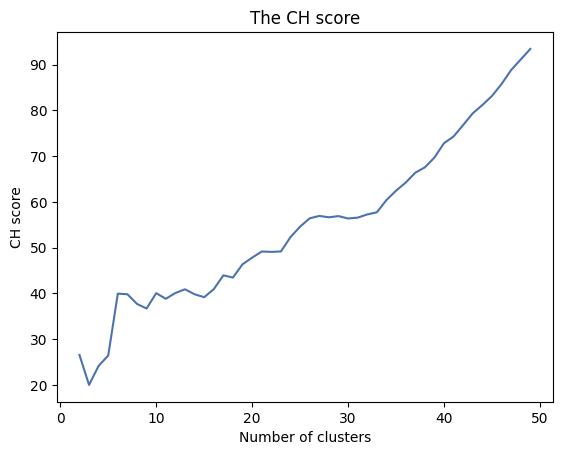

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 6, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

39.929256689963935

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 2: A, AAPL, ACN, AEP, AIG, AJG, AMT, ANET, AON, AZO, BDX, BIIB, BKNG, BLK, BMY, BSX, CDNS, CHTR, CL, CSX, CVX, DE, DG, EMR
Cluster 1: ABBV, COP, CSCO, CTAS, DIS, DOW
Cluster 3: ABT, ADBE, ADP, AMAT, AMGN, AXP, BA, BAC, BRK-B, CB, CCI, CMCSA, COF, CRM, CTVA, CVS, D, DHR, ECL
Cluster 0: ADI, ADM, ATVI, CAT, CI, CMG, DXCM, EL
Cluster 4: ADSK, AMD, AMZN, APD, APH, AVGO, C, COST, DUK, ELV
Cluster 5: CME


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AJG', 'ABBV', 'CTVA', 'ADM', 'COST', 'CME']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AJG', 0.2), ('ABBV', 0.2), ('CTVA', 0.2), ('ADM', 0.2), ('COST', 0.2), ('CME', 0.0)])

Expected annual return: 53.6%
Annual volatility: 16.2%
Sharpe Ratio: 3.20


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.1%
Annual volatility: 4.7%
Sharpe Ratio: -0.02
(-0.0009795622050787767, 0.04653330349474327, -0.021050777217857204)
Beta: 0.7058889624112241
Cumulative return: -0.11%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 4.0%
Annual volatility: 6.5%
Sharpe Ratio: 0.62
(0.03996258787271141, 0.06485740834925578, 0.6161607268904997)
Beta: 0.6647437224252573
Cumulative return: 3.88%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 18.1%
Annual volatility: 8.1%
Sharpe Ratio: 2.25
(0.1809640457975042, 0.0805754598299788, 2.245895290940368)
Beta: 0.5495813661133067
Cumulative return: 17.77%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 4.1%
Annual volatility: 4.7%
Sharpe Ratio: 0.87
(0.04115085577586813, 0.04704002244778549, 0.8748051900176207)
Beta: 0.6674092106705146
Cumulative return: 3.9%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 13.9%
Annual volatility: 4.7%
Sharpe Ratio: 2.97
(0.1385707088610717, 0.04661899230704881, 2.972408926138881)
Beta: 0.3712891998684852
Cumulative return: 13.24%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Формируем портфель

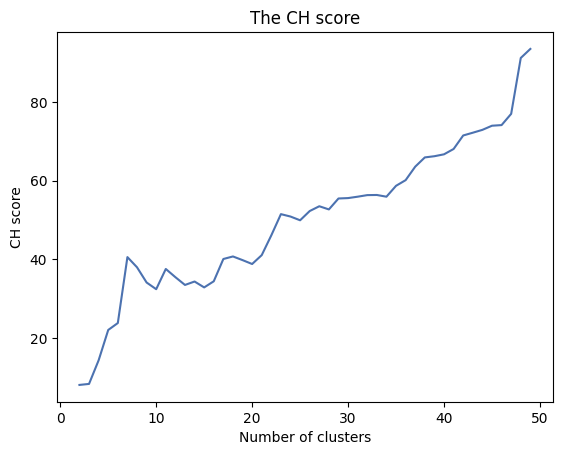

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

32.39789561417924

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 6: A, AAPL, ACN, AEP, AIG, AJG, AMT, ANET, AON, AZO, BDX, BIIB, BKNG, BLK, BMY, BSX, CDNS, CHTR, CL, CSX, CVX, DE, DG, EMR
Cluster 3: ABBV, CSCO
Cluster 0: ABT, ADBE, ADP, ADSK, AMAT, AMD, AMGN, AMZN, AVGO, AXP, BA, BAC, BRK-B, CB, CCI, CMCSA, COF, CRM, CTVA, CVS, D, DHR, ECL
Cluster 4: ADI, ADM, CI, DXCM, EL
Cluster 2: APD, COP, CTAS, DIS, DOW
Cluster 1: APH, C, DUK, ELV
Cluster 9: ATVI, CAT
Cluster 5: CME
Cluster 7: CMG
Cluster 8: COST


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AJG', 0.2), ('ABBV', 0.04667), ('CTVA', 0.07218), ('ADM', 0.2), ('CTAS', 0.0), ('APH', 0.0), ('CAT', 0.2), ('CME', 0.0), ('CMG', 0.08114), ('COST', 0.2)])

Expected annual return: 63.2%
Annual volatility: 16.0%
Sharpe Ratio: 3.82


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01',
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.7%
Annual volatility: 4.8%
Sharpe Ratio: -0.36
(-0.017118576946757127, 0.04769548487991392, -0.35891399342847025)
Beta: 0.666993540146022
Cumulative return: -1.65%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -1.9%
Annual volatility: 7.0%
Sharpe Ratio: -0.27
(-0.01917726493580663, 0.07009126822560868, -0.27360419380741047)
Beta: 0.7488167817806748
Cumulative return: -1.88%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 12.4%
Annual volatility: 8.4%
Sharpe Ratio: 1.49
(0.12444744505796056, 0.08362466951297758, 1.4881666592254545)
Beta: 0.6155492492143959
Cumulative return: 12.22%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -0.3%
Annual volatility: 5.4%
Sharpe Ratio: -0.06
(-0.0031123036093972803, 0.05379328587415126, -0.057856729865479434)
Beta: 0.8425741174294127
Cumulative return: -0.3%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 15.0%
Annual volatility: 4.1%
Sharpe Ratio: 3.69
(0.14964309321991842, 0.040537615599780794, 3.6914626330594444)
Beta: 0.38569044375998257
Cumulative return: 14.29%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Формируем портфель

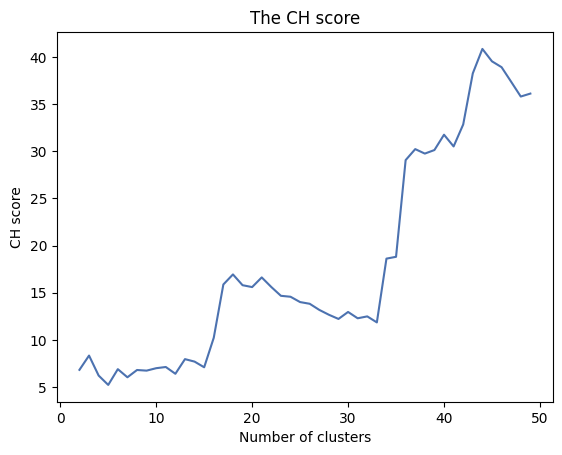

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

6.993573040872119

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEP, AIG, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APD, AVGO, AXP, AZO, BA, BAC, BDX, BIIB, BKNG, BLK, BMY, BRK-B, BSX, C, CB, CCI, CDNS, CHTR, CI, CL, COF, COP, CRM, CSX, CTAS, CTVA, CVS, CVX, D, DE, DG, DIS, DXCM, ECL, EL, ELV, EMR
Cluster 1: ABBV, CSCO
Cluster 6: APH
Cluster 2: ATVI, CAT
Cluster 3: CMCSA, DHR
Cluster 7: CME
Cluster 5: CMG
Cluster 9: COST
Cluster 4: DOW
Cluster 8: DUK


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AJG', 0.2), ('ABBV', 0.03367), ('APH', 0.0), ('CAT', 0.2), ('DHR', 0.2), ('CME', 0.0), ('CMG', 0.03199), ('COST', 0.2), ('DOW', 0.12453), ('DUK', 0.00981)])

Expected annual return: 61.5%
Annual volatility: 16.1%
Sharpe Ratio: 3.70


##### Проверяем стабильность

In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-02-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -4.5%
Annual volatility: 4.3%
Sharpe Ratio: -1.05
(-0.04487012023254586, 0.04259179396429766, -1.053492141471148)
Beta: 0.7055617483104817
Cumulative return: -4.29%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-03-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -7.9%
Annual volatility: 6.7%
Sharpe Ratio: -1.17
(-0.07851183284719072, 0.06731113032646764, -1.166401937783517)
Beta: 0.7678689594684622
Cumulative return: -7.67%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-01-01', 
                    '2022-04-01', 
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 8.6%
Sharpe Ratio: 0.45
(0.038759628326263125, 0.08641169017695664, 0.4485461197077607)
Beta: 0.7255811464726324
Cumulative return: 3.81%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-02-01', 
                    '2022-03-01',  
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: -3.5%
Annual volatility: 5.4%
Sharpe Ratio: -0.65
(-0.035330494371245455, 0.05438188372584802, -0.6496739713790508)
Beta: 0.8484593242275001
Cumulative return: -3.37%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks, 
                    index_df, 
                    '2022-03-01', 
                    '2022-04-01',
                    portfolio, 
                    weights)

Portfolio stats
Expected annual return: 13.0%
Annual volatility: 4.9%
Sharpe Ratio: 2.66
(0.13004254975764043, 0.04884651808222131, 2.662268568227222)
Beta: 0.632455786959107
Cumulative return: 12.43%
Index stats
Expected return: 5.6%
Volatility: 0.0%
